# Drugs Reviews Sentiment Analysis 



## Problem statement 
The aim of this project is to **compare different text representations** and **learning models** in the context of a classification task.

The dataset that we will use is the [Drug Reviews Dataset](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

We will understand and clean data by performing some Exploratory Data Analysis (EDA) and Text Preprocessing. 

Since the dataset does not provide a sentiment target variable, we will label the reviews using two different strategies: 
- Ratings
- VADER

We will use three different models: 
- CountVectorizer (BoW)
- TF-IDF 
- Dense Word Embedding (Glove)

For each of them we will try three different algorithms for classification: 
- Naive Bayes 
- Logistic Regression
- Random Forest  

For some of these configurations we will run a GridSearch to find the best hyper parameters.

For each model, we are going to calculate the $95\%$  **confidence interval on accuracy**.

Finally, we are going to compare our models in pairs through the **significance test** to determine if there is a model which can be considered better than the others; in particular, we will compare the performance of the best models found through the various grid searches by statistically compared the accuracy on the test set.

In the "Final Considerations" section we will report a summary of the results obtained and some considerations on them.

------

**NOTES**

Some sections may take a long time to run.

Therefore, in [this folder](https://drive.google.com/drive/folders/1w2Dw7jpOlvdV4gUDqPO63VXQBp_bhM-0?usp=sharing)  you can find the files to load during the execution; in particular:
- ***df.p*** to skip the "Data Understanding", "Text Preprocessing" and "Labeling" sections, and go directly to "Models -> Load Clean Dataset".
- ***X_train.p, X_test.p, Y_train.p, Y_test.p*** to skip the preparation part of the embedding matrix and data in the "Dense Word Embedding" section and go directly to "Dense Word Embedding -> Load Input Data".




## Configuration
We import all the required packages.

In [ ]:
!pip install pyspellchecker
!pip install vaderSentiment
!pip install contractions

     |████████████████████████████████| 2.7MB 6.1MB/s 
     |████████████████████████████████| 133kB 6.6MB/s 
     |████████████████████████████████| 266kB 6.0MB/s 
     |████████████████████████████████| 327kB 8.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85265 sha256=fe320af66f77d6d93c8de1990069aa2bf3ffd630baa0db97a466acc228c433e9
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [ ]:
# Utility
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import math
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import os 
import pickle 
from time import time
import random

# Extra tools for data preprocessing 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re
from functools import reduce
from nltk.stem.snowball import SnowballStemmer
from collections import OrderedDict


# Vader 
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Downloader for Glove Word Embedding 
import gensim
import gensim.downloader as gloader

# WordCloud
from wordcloud import WordCloud, STOPWORDS

# Contractions
import contractions

# Sklearn 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

#####################
#  REPRODUCIBILITY  #
#####################

# Seed value
SEED_VALUE= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED_VALUE)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## The Drug Review Dataset
The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The dataset does not provide a sentiment label assigned to each review (*positive* or *negative*); to address this problem we can use the following strategies:  
- create a target feature out of ratings and then predict the sentiment of the reviews.
- use **VADER** (Valence Aware Dictionary and sEntiment Reasoner)

But first let's take a look at the data.

### Dataset structure
The data is split into a train (75%) a test (25%) partition.

- **ID** (numerical): unique identifier associated to the usert who inserted the review
- **drugName** (categorical): name of drug
- **condition** (categorical): name of condition
- **review** (text): patient review
- **rating** (numerical): 10 star patient rating
- **date** (date): date of review entry
- **usefulCount** (numerical): number of users who found the review useful

The structure of the data is based on the fact that a patient with a unique ID purchases a drug that meets his condition, writes a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

**Example**

--------
{"**ID**": 163740, "**drugName**":	Mirtazapine, "**condition**":	Depression, "**review**":	""I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."", "**rating**":	10.0, "**date**":	February 28, 2012, "**usefulCount**":	22}

### Download Data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip  

--2021-03-06 17:29:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  36.1MB/s    in 1.1s    

2021-03-06 17:29:24 (36.1 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]



In [ ]:
# Unzip data
!unzip drugsCom_raw.zip          

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [ ]:
# Read the files with the pandas dataFrame
# We pass the '\t' delimeter as argument to prevent parsing errors 

train_df = pd.read_csv('drugsComTest_raw.tsv',delimiter='\t')
test_df = pd.read_csv('drugsComTrain_raw.tsv', delimiter='\t')   

### Merge Train and Test data

To simplify Data Understanding and Data Preprocessing we can **merge** train and test data, as there are no target labels. Then we will split the data into 70 : 30 ratio for training and testing. 

In [ ]:
# Merge train and test data 
merge = [train_df,test_df]
df = pd.concat(merge,ignore_index=True)

In [ ]:
# Check the shape of merged data
df.shape   

(215063, 7)

### Inspect Data
In this section we are going to briefly inspect the data.

In [ ]:
'''
Uncomment the following line if you need to read the content of the dataframes 
without truncation 
'''
#pd.set_option('display.max_colwidth', -1)

'\nUncomment the following line if you need to read the content of the dataframes \nwithout truncation \n'

In [ ]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [ ]:
# Rename columns
df.columns = ['ID','drugName','condition','review','rating','date','usefulCount']   

In [ ]:
# Convert date to datetime 
df['date'] = pd.to_datetime(df['date'])  

In [ ]:
# Confirm conversion
df['date'].head() 

0   2012-02-28
1   2009-05-17
2   2017-09-29
3   2017-03-05
4   2015-10-22
Name: date, dtype: datetime64[ns]

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ID           215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    213869 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  float64       
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 11.5+ MB
None


### Data Understanding
Before working on our dataset, we want to explore it to find out interesting insights and irregularities.

We will look at some features and try to find out interesting facts and patterns from them. 

**Check for Duplicates**

Check number of unique ` ID`  to see if there is any duplicate record in our dataset.

We compare the unique number of IDs and the length of the merged dataset to see if the same customer has written multiple reviews, and check that there isn't more than one review for one customer.

As can be seen by running the cell below, there are 215063 unique IDs, meaning that **every record is unique**.

In [ ]:
# Check unique IDs
df['ID'].nunique()

215063

**Check the Description**

From the table below we can notice that: 
- Top drugName is Levonorgestrel, It will be intresting to see for what condition it is used.
- Top condition is Birth Control.
- Top review is just a single word "Good", but it has very small count (39).
- Most single day review came on 1-Mar-16; it will be interesting to investigate this date and see for which drugName and which conditions these reviews were for.

In [ ]:
df.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,ID,drugName,condition,review,rating,date,usefulCount
count,215063.000000,215063,213869,215063,215063.000000,215063,215063.000000
unique,NaN,3671,916,128478,NaN,3579,NaN
top,NaN,Levonorgestrel,Birth Control,"""Good""",NaN,2016-03-01 00:00:00,NaN
freq,NaN,4930,38436,39,NaN,185,NaN
first,NaN,NaN,NaN,NaN,NaN,2008-02-24 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-12-12 00:00:00,NaN
mean,116039.364814,NaN,NaN,NaN,6.990008,NaN,28.001004
std,67007.913366,NaN,NaN,NaN,3.275554,NaN,36.346069
min,0.000000,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,58115.500000,NaN,NaN,NaN,5.000000,NaN,6.000000


**Check the percentage of null values in each column**

As can be seen by running the cell below, we have null values in just 1 column, i.e **condition**. We will leave the null values in that column for now and we will remove them during the **Data Preprocessing** phase. 


In [ ]:
df.isnull().sum()/df.shape[0]

ID             0.000000
drugName       0.000000
condition      0.005552
review         0.000000
rating         0.000000
date           0.000000
usefulCount    0.000000
dtype: float64

**Check number of unique values in drugName and condition**

As can be seen by running the cells below, there are 3671 drugName and only 916 conditions. So there are conditions which has multiple drugs.

In [ ]:
#check number of unique values in drugName
print(df['drugName'].nunique())

3671


In [ ]:
#check number of unique values in condition
print(df['condition'].nunique())

916


**Check top 20 conditions** 

From graph below we can observe that:

- Birth control is twice as big as anyone, around 38,000.
- The count of most of the conditions for top 20 conditions is between 5000 and 10000

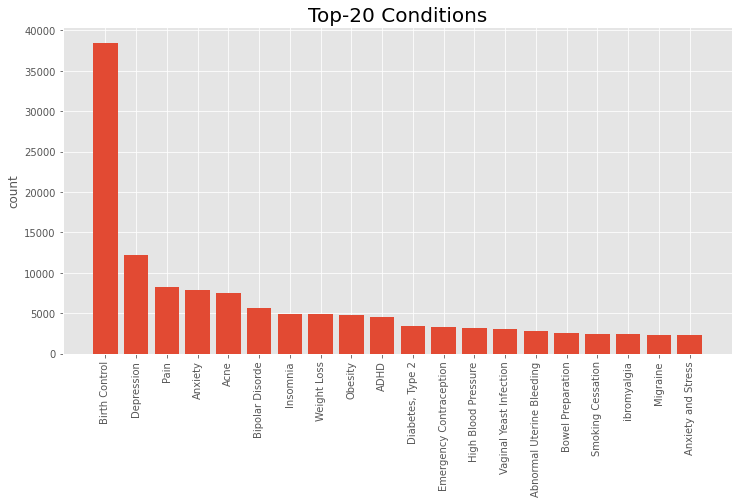

In [ ]:
# plot a bargraph to check top 20 conditions
plt.figure(figsize=(12,6))
conditions = df['condition'].value_counts(ascending = False).head(20)

plt.bar(conditions.index,conditions.values)
plt.title('Top-20 Conditions',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

**Plot the 20 rarest conditions**

From the graph below we can observe that:
- The 20 rarest conditions have just single counts in our dataset. They may be the rare conditions.
- There are conditions whose name are strange because they start with "61</span>users found this comment helpful". We will deal with these noise later, in **Check number of Drugs per condition** section.

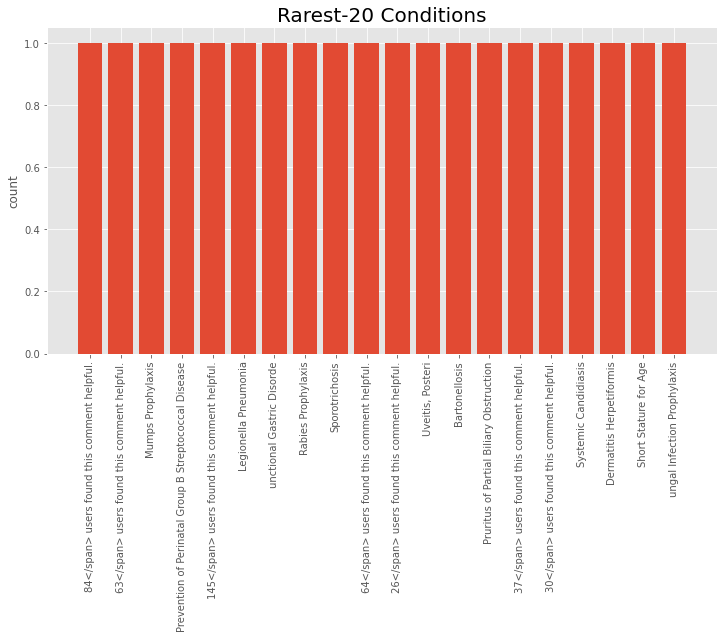

In [ ]:
# plot a bargraph to check bottom 20 conditions
plt.figure(figsize=(12,6))
conditions_bottom =df['condition'].value_counts(ascending = False).tail(20)

plt.bar(conditions_bottom.index,conditions_bottom.values)
plt.title('Rarest-20 Conditions',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

**Check top 20 drugName**

From the graph below we can observe that: 
- The top drugName is Levonorgestrel
- The top 3 drugName has count around 4000 and above.
- Most of the drugName counts are around 1500 if we look at top 20

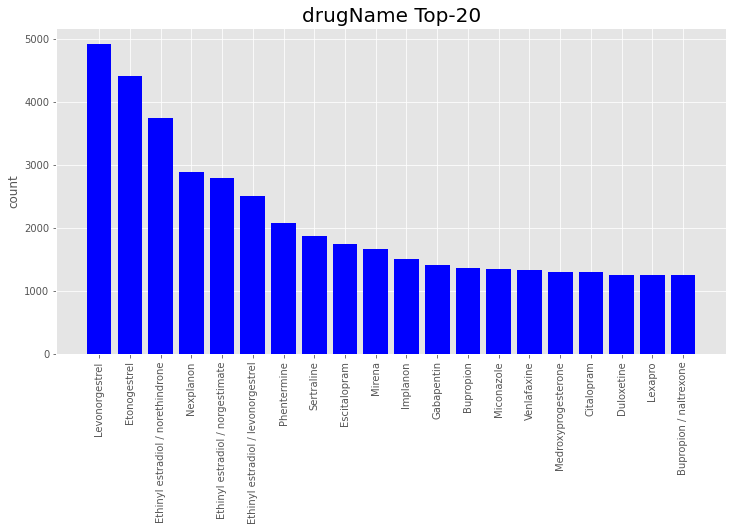

In [ ]:
#plot a bargraph to check top 20 drugName
plt.figure(figsize=(12,6))
drugName_top = df['drugName'].value_counts(ascending = False).head(20)

plt.bar(drugName_top.index,drugName_top.values,color='blue')
plt.title('drugName Top-20',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

**Check 20 rarest drugNames**

From the graph below we can observe that the bottom 20 drugName has count 1. These might be the drugs that are used for rare conditions or that are new in market.


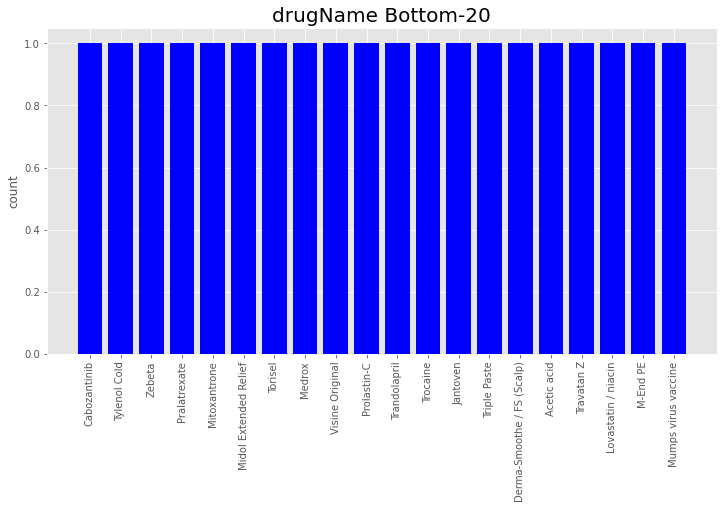

In [ ]:
#plot a bargraph to check rarest 20 drugName
plt.figure(figsize=(12,6))
drugName_bottom = df['drugName'].value_counts(ascending = False).tail(20)

plt.bar(drugName_bottom.index,drugName_bottom.values,color='blue')
plt.title('drugName Bottom-20',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

**Check Ratings Distribution**

From the graph below we can notice that:
-  most of the ratings are high (with ratings 10 and 9). 
- rating 1 is also high 

These two observations show the extreme ratings of the user. We can say that the users mostly prefer to rate when the drugs are either very useful to them or the drugs fails/there is some side effects. About $70\%$ of the values have rating greater than $7$, so we can say that from the point of view of ratings the **dataset is very unbalanced**. 

In [ ]:
# print ratings distribution
ratings_ = df['rating'].value_counts().sort_values(ascending=False).reset_index().\
                    rename(columns = {'index' :'rating', 'rating' : 'counts'})
ratings_['percent'] = 100 * (ratings_['counts']/df.shape[0])
print(ratings_)

   rating  counts    percent
0    10.0   68005  31.620967
1     9.0   36708  17.068487
2     1.0   28918  13.446292
3     8.0   25046  11.645890
4     7.0   12547   5.834104
5     5.0   10723   4.985981
6     2.0    9265   4.308040
7     3.0    8718   4.053696
8     6.0    8462   3.934661
9     4.0    6671   3.101882


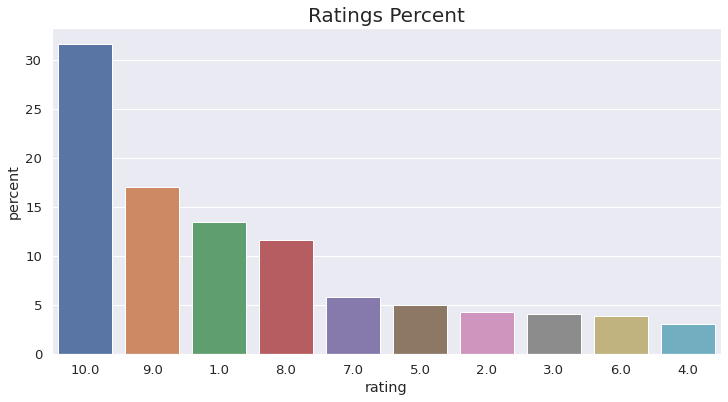

In [ ]:
# plot ratings distribution 
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
sns.barplot(x = ratings_['rating'], y = ratings_['percent'],order = ratings_['rating'])
plt.title('Ratings Percent',fontsize=20)
plt.show()

**Check number of Drugs per condition**

- There are values in ` condition`  like `3 </span> user found this comment helpful`, `4</span> users found this comment helpful`; these are the noisy records present in our dataset. The dataset appears to have been extracted through webscraping, so the values were wrongly fed in here.

- As can be seen below, there are only $0.54\%$ values with `</span>` type data. We can remove these data from our dataset as we won't lose a lot of information by removing them.

- Furthermore, from the results below we can observe that the top value is `not listed/othe` (592 unique drugs for `not / listed othe`).
    
  It might be possible that the user did not mention his/her condition as sometimes people do not want to reveal thier disorders.

  There are 2 options to deal with these values
  - Check the condition associated with the drugs and replace the values.
  - drop the values as these only accounts for 0.27 % of total data. 

  To save our time we will drop the nosiy data.

In [ ]:
# Let's check the number of drugs/condition
df.groupby('condition')['drugName'].nunique().sort_values(ascending=False).head(20)

condition
Not Listed / Othe                             253
Pain                                          219
Birth Control                                 181
High Blood Pressure                           146
Acne                                          127
Depression                                    115
Rheumatoid Arthritis                          107
Diabetes, Type 2                               97
Allergic Rhinitis                              95
Insomnia                                       85
Osteoarthritis                                 84
Bipolar Disorde                                82
Anxiety                                        81
Abnormal Uterine Bleeding                      77
Endometriosis                                  64
3</span> users found this comment helpful.     62
Psoriasis                                      61
Migraine                                       60
ADHD                                           58
4</span> users found this comment helpfu

Let's look at '`3 </span> user found this comment helpful`'

In [ ]:
span_data = df[df['condition'].str.contains('</span>',case=False,regex=True) == True]
print('Number of rows with </span> values : ', len(span_data))
noisy_data_ = 100 * (len(span_data)/df.shape[0])
print('Total percent of noisy data {} %  '.format(noisy_data_))

Number of rows with </span> values :  1171
Total percent of noisy data 0.5444916140851751 %  


In [ ]:
# Drop the noise
df.drop(span_data.index, axis = 0, inplace=True)

Now let's look at the "`not listed/othe`"

In [ ]:
# Check the percentage of 'not listed / othe' conditions

not_listed = df[df['condition'].str.contains('not listed / othe',case=False,regex=True) == True] 
print('Number of not_listed values : ', len(not_listed))
percent_not_listed = 100 * len(not_listed)/df.shape[0]
print('Total percent of noisy data :  {} %  '.format(percent_not_listed))

Number of not_listed values :  592
Total percent of noisy data :  0.2767751949582032 %  


In [ ]:
# Drop noisy data
df.drop(not_listed.index, axis = 0, inplace=True)

In [ ]:
# After removing the noisy data, let's check the shape
df.shape[0]

213300

### Text Preprocessing

During the **Data Understanding** phase we have already removed some noisy data. Let's continue the exploration of data and perform some preprocessing. 

#### Missing Values Removal

As we have observed during the **Data Understanding** phase, we have null  values in `condition`. We will drop the records with null values as they only account for $0.5\%$ of total data.

However, it must be specified that the presence of these null values would not have affected our analysis, since we will be interested in analyzing the reviews. In the event that there were null values in the **reviews**, we would have gone to eliminate the corresponding lines, in order not to generate false or noisy results during classification.

In [ ]:
# Check the null values
df.isnull().sum()

ID                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [ ]:
# Drop the null values
df.dropna(inplace=True, axis=0)

#### Review Preprocessing 
In this section we are going to preprocess the **reviews**.

We had to define three types of preprocessing.

In particular:
* The first preprocessing pipeline will be used to extract the `clean_text` to be used in **Rating-labeling** 
* The second preprocessing pipeline will be used to extract the `clean_text` to be exploited in **VADER-labeling**.
* The third preprocessing pipeline will be used to extract the `clean_text` to be exploited in the construction of the **Dense Word Embedding**.

The order of execution within the pipelines is important.


**Pipeline 1**:
* strip html
* strip text
* remove stopwords 
* replace special characters 
* filter out uncommon symbols
* combine whitespace
* lower text 
* stemming 


**Pipeline 2**:
* strip html
* strip text

**Pipeline 3**:
* strip html
* strip text 
* remove stopwords 
* replace special characters 
* filter out uncommon symbols
* combine whitespace
* lower text 
* expand contractions 

----
***NOTES ABOUT STEMMING***

The most famous stemming algorithms are:
- **Porter Stemmer**: it was designed in the 1980s (the development on it is frozen) and its main concern is removing the common endings to words so that they can be resolved to a common form. 
- **Snowball stemmer**: it is also known as the Porter2 stemming algorithm. It is considered to be better and more "aggressive" than the Porter stemmer. 

We will use the Snowball Stemmer. 

 
---------------------------

***NOTES ABOUT PIPELINE 2***:

As you can see from the lists above, in the second pipeline (compared to the first):
- we do not remove the punctuation and special characters
- we do not lower the text
- we do not perform stemming
- we do not remove the stopwords

We need to use this pipeline because VADER assigns a polarity in reference to the following as well:

- Punctuation
- Capitalization
- Conjunctions
- Preceding Tri-gram
- Emojis, Slangs, and Emoticons

Please, refer to the **VADER based Section** for furhter details. 

---------------------------

***NOTES ABOUT PIPELINE 3***:

As you can see from the lists above, in the third pipeline (compared to the first):
- we do not perform stemming
- we expand contractions 

We need to use this pipeline because otherwise we would have too much OOV terms (**Glove-300**, the pretrained word embedding that we will use, is trained on non-stemmed words).  


In [ ]:
# Check first three reviews
for i in train_df['review'][0:3]:
    print(i,'\n')

"I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me." 

"My son has Crohn&#039;s disease and has done very well on the Asacol.  He has no complaints and shows no side effects.  He has taken as many as nine tablets per day at one time.  I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically." 

"Quick reduction of symptoms" 



##### Check Stopwords
First, let's see what words are used as stopwords.




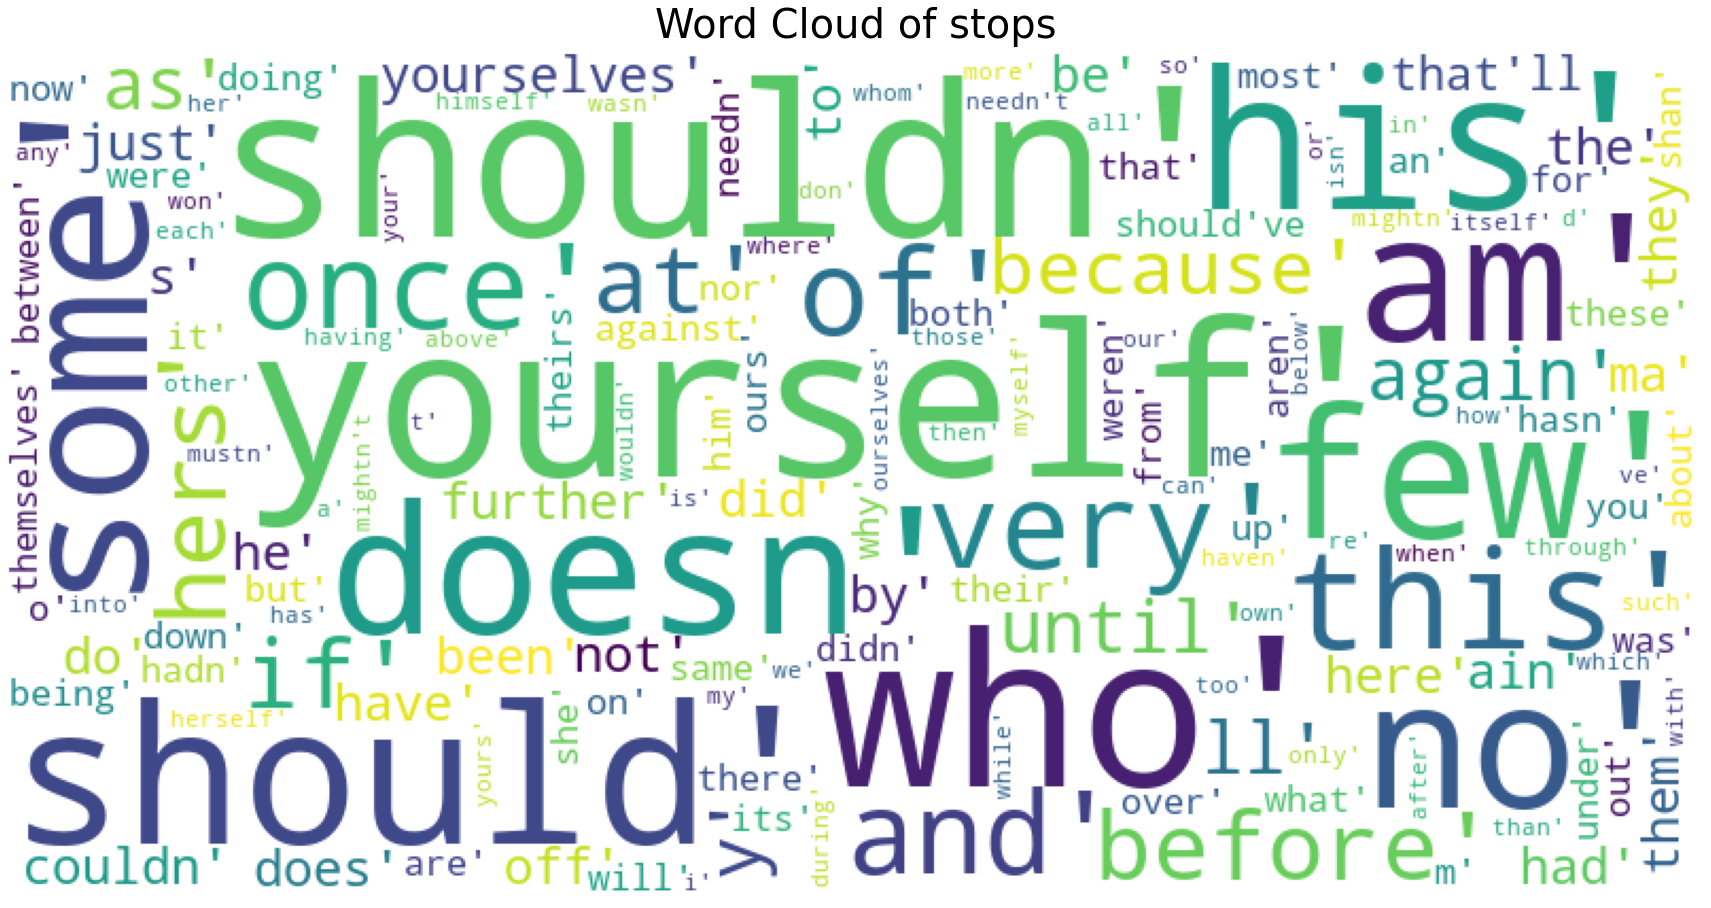

In [ ]:
## Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
stops = set(stopwords.words('english'))
plot_wordcloud(stops, title="Word Cloud of stops")

There are many words that include not, like needn't. These words are key parts of emotional analysis, so we will remove them from stopwords.

In [ ]:
# List of preserved negations
NEG_LIST = ['nor',
            'no', 
            'needn', 
            'weren',
            'hasn\'t',
            'isn\'t',
            'wasn',
            'don\'t',
            'couldn\'t',
            'don', 
            'hasn',
            'won\'t',
            'must',
            'didn',
            'can\'t'
            'haven\'t',
            'weren\'t ',
            'didn\'t',
            'mustn\'t',
            'wouldn\'t',
            'doesn\'t',
            'needn\'t',
            'wasn\'t',
            'aren\'t',
            'couldn',
            'isn',
            'dosen',
            'shouldn\'t',
            'mightn',
            'mightn\'t',
            'not',
            'never'
            'aren',
            "aren't",
            'couldn',
            "couldn't",
            'didn',
            "didn't",
            'doesn',
            "doesn't",
            'hadn',
            "hadn't",
            'hasn',
            "hasn't",
            'haven',
            "haven't",
            'isn',
            "isn't",
            'ma',
            'mightn',
            "mightn't",
            'mustn',
            "mustn't",
            'needn',
            "needn't",
            'shan',
            "shan't",
            'shouldn',
            "shouldn't",
            'wasn',
            "wasn't",
            'weren',
            "weren't",
            'won',
            "won't",
            'wouldn',
            "wouldn't"]

##### Preprocessing Pipelines

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;:.#+_?!"$%&@~]\t')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z ]')
COMBINE_WHITESPACE = re.compile(r"\s+")

class CleanText(BaseEstimator, TransformerMixin):

  # STOPWORDS
  def stopwords(self, text):
    """Removes english stopwords"""
    stop_words = set(nltk.corpus.stopwords.words('english'))     
    stop_words_no_neg = stop_words - set(NEG_LIST)
    text = ' '.join([word for word in text.split() if word not in stop_words_no_neg ])
    return text 

  # HTML TAGS 
  def strip_html(self, text):
    """
    Removes any HTML tags
    """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

  # STRIP TEXT
  def strip_text(self, text):
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()
    
  # REPLACE SPECIAL CHARACTER
  def replace_special_characters(self, text):
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub('', text)

  # FILTER UNCOMMON SYMBOLS 
  def filter_out_uncommon_symbols(self, text):
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub(' ', text)

  # COMBINE WHITESPACE 
  def combine_whitespace(self, text):
    """
    Removes multiple white-spaces from text.
    Example:
    Input: 'This    assignment is    cool'
    Output: 'This assignment is cool'
    """
    return COMBINE_WHITESPACE.sub(" ", text).strip()

  # LOWER TEXT
  def lower(self, text):
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new york city'
    """

    return text.lower()

  # STEMMING
  def stemming(self, text):
    """
    Remove the suffixes from the words to 
    get the root form of the word 
    Example:
    Input: 'Wording'
    Output: 'Word'
    """
    stemmer = SnowballStemmer('english')
    text = ' '.join(stemmer.stem(token) for token in nltk.word_tokenize(text))
    return text 

  # CONTRACTIONS 
  def expand_contractions(self, input_text):
      """ Transform contracted words into their standard form. """
      return contractions.fix(input_text)

  def fit(self, X, y=None, **fit_params):
      return self

  # PIPELINE 1
  def transform(self, X, **transform_params):
      
    clean_X = X.apply(self.strip_html)\
            .apply(self.strip_text)\
            .apply(self.stopwords)\
            .apply(self.replace_special_characters)\
            .apply(self.filter_out_uncommon_symbols)\
            .apply(self.combine_whitespace)\
            .apply(self.lower)\
            .apply(self.stemming)

    return clean_X
  
  # PIPELINE 2
  def transform_vader(self, X, **transform_params): 
    clean_X = X.apply(self.strip_html)\
            .apply(self.strip_text)
    return clean_X
  

  # PIPELINE 3
  def transform_embedding(self, X, **transform_params): 
    clean_X = X.apply(self.strip_html)\
            .apply(self.strip_text)\
            .apply(self.stopwords)\
            .apply(self.replace_special_characters)\
            .apply(self.filter_out_uncommon_symbols)\
            .apply(self.combine_whitespace)\
            .apply(self.lower)\
            .apply(self.expand_contractions)

    return clean_X


In [ ]:
# WARNING: time consuming! 5-8 min

%%time 

ct = CleanText() 
df['clean_text'] = ct.fit(df.review).transform(df.review)


CPU times: user 3min 56s, sys: 3.13 s, total: 3min 59s
Wall time: 4min


In [ ]:
%%time 
# VADER requires a different preprocessing pipeline
ct = CleanText() 
df['VADER_clean_text'] = ct.fit(df.review).transform_vader(df.review)

CPU times: user 12.9 s, sys: 108 ms, total: 13.1 s
Wall time: 13 s


In [ ]:
%%time 
# Dense Embeddings require a different preprocessing pipeline 
ct = CleanText() 
df['embedding_clean_text'] = ct.fit(df.review).transform_embedding(df.review)

CPU times: user 55 s, sys: 2.81 s, total: 57.8 s
Wall time: 57.8 s


In [ ]:
# Keep only those columns that will be used in from now on
df = df[['rating', 'clean_text', 'VADER_clean_text', 'embedding_clean_text']]

In [ ]:
df.head()

,rating,clean_text,VADER_clean_text,embedding_clean_text
0,10.0,i ve tri antidepress year citalopram fluoxetin...,"""I've tried a few antidepressants over the yea...",i ve tried antidepressants years citalopram fl...
1,8.0,my son crohn s diseas done well asacol he no c...,"""My son has Crohn's disease and has done very ...",my son crohn s disease done well asacol he no ...
2,9.0,quick reduct symptom,"""Quick reduction of symptoms""",quick reduction symptoms
3,9.0,contrav combin drug use alcohol smoke opioid c...,"""Contrave combines drugs that were used for al...",contrave combines drugs used alcohol smoking o...
4,9.0,i birth control one cycl after read review typ...,"""I have been on this birth control for one cyc...",i birth control one cycle after reading review...


## Labeling


##### **Rating based**

Here we create a sentiment feature from ratings following this strategy: 
- if ` rating`  $>$ 5 , ` sentiment`  = 1 (positive)
- if ` rating`  $\leq$ 5,  ` sentiment`  = 0 (negative) 

In [ ]:
# Create sentiment feature from ratings
df['RATING_sentiment'] = df["rating"].apply(lambda x: 1 if x > 5 else 0)

In [ ]:
df.head()

,rating,clean_text,VADER_clean_text,embedding_clean_text,RATING_sentiment
0,10.0,i ve tri antidepress year citalopram fluoxetin...,"""I've tried a few antidepressants over the yea...",i ve tried antidepressants years citalopram fl...,1
1,8.0,my son crohn s diseas done well asacol he no c...,"""My son has Crohn's disease and has done very ...",my son crohn s disease done well asacol he no ...,1
2,9.0,quick reduct symptom,"""Quick reduction of symptoms""",quick reduction symptoms,1
3,9.0,contrav combin drug use alcohol smoke opioid c...,"""Contrave combines drugs that were used for al...",contrave combines drugs used alcohol smoking o...,1
4,9.0,i birth control one cycl after read review typ...,"""I have been on this birth control for one cyc...",i birth control one cycle after reading review...,1


##### **VADER based**

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

VADER uses a combination of a sentiment lexicon (which is a list of lexical features e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

VADER analyses sentiments primarily based on certain key points:
- **Punctuation**: The use of an exclamation mark(!), increases the magnitude of the intensity without modifying the semantic orientation. For example, “The food here is good!” is more intense than “The food here is good.” and an increase in the number of (!), increases the magnitude accordingly.
- **Capitalization**: Using upper case letters to emphasize a sentiment-relevant word in the presence of other non-capitalized words, increases the magnitude of the sentiment intensity. For example, “The food here is GREAT!” conveys more intensity than “The food here is great!
- **Degree modifiers**: Also called intensifiers, they impact the sentiment intensity by either increasing or decreasing the intensity. For example, “The service here is extremely good” is more intense than “The service here is good”, whereas “The service here is marginally good” reduces the intensity.
- **Conjunctions**: Use of conjunctions like “but” signals a shift in sentiment polarity, with the sentiment of the text following the conjunction being dominant. “The food here is great, but the service is horrible” has mixed sentiment, with the latter half dictating the overall rating.
- **Preceding Tri-gram**: By examining the tri-gram preceding a sentiment-laden lexical feature, we catch nearly 90% of cases where negation flips the polarity of the text. A negated sentence would be “The food here isn’t really all that great”.
- **Emojis, Slangs, and Emoticons**: VADER performs very well with emojis, slangs, and acronyms in sentences. 

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive)

-----

**Strategy**

- if `compound_score`  $\geq$ 0 , ` sentiment`  = 1 (positive)
- if `compound_score`  $<$ 0,  ` sentiment`  = 0 (negative) 

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df['VADER_sentiment'] = df['VADER_clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
df.head(10)

,rating,clean_text,VADER_clean_text,embedding_clean_text,RATING_sentiment,VADER_sentiment
0,10.0,i ve tri antidepress year citalopram fluoxetin...,"""I've tried a few antidepressants over the yea...",i ve tried antidepressants years citalopram fl...,1,-0.5267
1,8.0,my son crohn s diseas done well asacol he no c...,"""My son has Crohn's disease and has done very ...",my son crohn s disease done well asacol he no ...,1,0.7539
2,9.0,quick reduct symptom,"""Quick reduction of symptoms""",quick reduction symptoms,1,0.0000
3,9.0,contrav combin drug use alcohol smoke opioid c...,"""Contrave combines drugs that were used for al...",contrave combines drugs used alcohol smoking o...,1,0.6810
4,9.0,i birth control one cycl after read review typ...,"""I have been on this birth control for one cyc...",i birth control one cycle after reading review...,1,0.9559
5,4.0,4 day first 2 week use arm face put vaselin li...,"""4 days in on first 2 weeks. Using on arms an...",4 days first 2 weeks using arms face put vasel...,0,0.6924
6,6.0,i ve copper coil 3 month now i realli excit th...,"""I've had the copper coil for about 3 months n...",i ve copper coil 3 months now i really excited...,1,-0.3393
7,9.0,this great me i ve 2 week last week i 3 headac...,"""This has been great for me. I've been on it f...",this great me i ve 2 weeks last week i 3 heada...,1,0.7479
8,7.0,ive methadon ten year current i tri get drug i...,"""Ive been on Methadone for over ten years and ...",I have methadone ten years currently i trying ...,1,0.2023
9,2.0,i pill almost two year it work far not get pre...,"""I was on this pill for almost two years. It d...",i pill almost two years it work far not gettin...,0,-0.9303


In [ ]:
positive_num = len(df[df['VADER_sentiment'] >=0.00])
negative_num = len(df[df['VADER_sentiment'] <-0.00])
positive_num, negative_num

(109023, 103083)

In [ ]:
# Map positive values to positive sentiment and negative values to negative sentiment
df['VADER_sentiment']= df['VADER_sentiment'].map(lambda x:int(1) if x>=0.00 else int(0) )

In [ ]:
df.head(10)

,rating,clean_text,VADER_clean_text,embedding_clean_text,RATING_sentiment,VADER_sentiment
0,10.0,i ve tri antidepress year citalopram fluoxetin...,"""I've tried a few antidepressants over the yea...",i ve tried antidepressants years citalopram fl...,1,0
1,8.0,my son crohn s diseas done well asacol he no c...,"""My son has Crohn's disease and has done very ...",my son crohn s disease done well asacol he no ...,1,1
2,9.0,quick reduct symptom,"""Quick reduction of symptoms""",quick reduction symptoms,1,1
3,9.0,contrav combin drug use alcohol smoke opioid c...,"""Contrave combines drugs that were used for al...",contrave combines drugs used alcohol smoking o...,1,1
4,9.0,i birth control one cycl after read review typ...,"""I have been on this birth control for one cyc...",i birth control one cycle after reading review...,1,1
5,4.0,4 day first 2 week use arm face put vaselin li...,"""4 days in on first 2 weeks. Using on arms an...",4 days first 2 weeks using arms face put vasel...,0,1
6,6.0,i ve copper coil 3 month now i realli excit th...,"""I've had the copper coil for about 3 months n...",i ve copper coil 3 months now i really excited...,1,0
7,9.0,this great me i ve 2 week last week i 3 headac...,"""This has been great for me. I've been on it f...",this great me i ve 2 weeks last week i 3 heada...,1,1
8,7.0,ive methadon ten year current i tri get drug i...,"""Ive been on Methadone for over ten years and ...",I have methadone ten years currently i trying ...,1,1
9,2.0,i pill almost two year it work far not get pre...,"""I was on this pill for almost two years. It d...",i pill almost two years it work far not gettin...,0,0


#### **Sentiment Labels Comparison**
Here we want to discover if the two methods actually have associated a high percentage of different "sentiment" labels.

In the event that the two methods have produced almost the same labels, we will proceed with the use of a single dataset.

----------------------------
**Results**

By running the cells below we discovered that about $36\%$ of reviews got a different label.

I manually analyzed some of the reviews that got a different label through the two methodologies (Rating based and VADER based). 

From my **non-exhaustive** exploration of the dataset, I was able to ascertain that, according to the feeling I have when reading the selected reviews, the label associated by VADER turns out to be wrong. For example, reviews like "Horrible!" obtained the label "1", while it is established that "Horrible" is commonly associated with a negative sentiment (it agrees with the **rating** assigned in most cases).

It would be interesting to further investigate this problem, to find out what the nature of the discrepancies actually is, through both linguistic and statistical analysis.

Since this type of analysis eludes the scope of this project, I will keep only the labels associated through the "RATING-based" methodology, which I consider most significant.

Furthermore, it must be said that this experiment was useful in experimenting with another technique and discovering the existence and use of VADER-Sentiment Analyzer.

In [ ]:
df.shape

(212106, 6)

In [ ]:
# Compare the sentiment associated by the two methods to each review 
count_differences = len(df.query('VADER_sentiment != RATING_sentiment'))
print("There are {} different values".format(count_differences))
print("The percentage of different values is {:.1f} %".format(((count_differences/df.shape[0])*100)))


There are 75547 different values
The percentage of different values is 35.6 %


In [ ]:
differences = df.query('VADER_sentiment != RATING_sentiment')

In [ ]:
differences.head()

,rating,clean_text,VADER_clean_text,embedding_clean_text,RATING_sentiment,VADER_sentiment
0,10.0,i ve tri antidepress year citalopram fluoxetin...,"""I've tried a few antidepressants over the yea...",i ve tried antidepressants years citalopram fl...,1,0
5,4.0,4 day first 2 week use arm face put vaselin li...,"""4 days in on first 2 weeks. Using on arms an...",4 days first 2 weeks using arms face put vasel...,0,1
6,6.0,i ve copper coil 3 month now i realli excit th...,"""I've had the copper coil for about 3 months n...",i ve copper coil 3 months now i really excited...,1,0
13,10.0,no problem watch eat,"""No problems, watch what you eat.""",no problems watch eat,1,0
18,6.0,this medic help sleep eventu becam ineffect sl...,"""This medication helped me sleep, but eventua...",this medication helped sleep eventually became...,1,0


In [ ]:
# Store only the data that we will use in our classifiers 
df = df[['clean_text', 'embedding_clean_text', 'RATING_sentiment']]


In [ ]:
# Save clean dataset 
filename = 'df.p'
with open(filename, 'wb') as outfile:
    pickle.dump(df, outfile)

## Models
We will use three different models: 
- CountVectorizer (BoW)
- Dense Word Embedding 

For each of them we will try three different algorithms for classification: 
- Naive Bayes 
- Logistic Regression
- Random Forest 

As specified in the problem statement, for some classifiers and models we will perform a Grid Search on certain parameters in order to find the best hyperparameters for each configuration.

We were unable to perform a Grid Search on various parameters for each model due to high runtime. It would certainly be interesting to repeat the tests by carefully selecting the hyper paraemeters for the models for which we were unable to perform the Grid Search.

We will compute the **confidence interval** of the accuracy for each best model (resulting from the Grid Search) and, as we anticipated at the beginning, we will perform the **significance test** to compare each pair of best models. 

Exploiting the significance tests we will understand if there is a model which is better than the others. 

### Load clean dataset

Always run the cell below before moving to one of the following section: 
- CountVectorizer 
- TF-IDF Vectorizer
- Dense Word Embedding

In [ ]:
# Load clean dataset 
try:
  filename = 'df.p'
  with open(filename, 'rb') as outfile:
      df = pickle.load(outfile)
except:
  print("\n\nFile not found!\n")
  raise

### Utils
In this section we define the functions that we will need to calculate the **confidence interval** for each model and to perform the **significance test**.

The **significance test function** will be used in the **"Models Comparison" section**.

In [ ]:
def get_confidence_interval(n, acc, alpha):
  
  """
  Return the confidence interval for the confidence level 
  specified by the alpha parameter
  NOTE: Use this method only if n > 30

  Parameters
  ----------
  - n : cardinality of the test set 
  - acc : accuracy of the model 
  - alpha : significance level. The confidence level will be 1-alpha

  Return
  ------
  - [p_min, p_max]: list of lower and upper values of the confidence interval 
 
 """
  # Compute confidence level 
  conf_level = 1-alpha

  # Retrieve the value of Z for the specified confidence level
  Z = scipy.stats.norm.ppf((1+conf_level)/2)

  # Compute p_min and p_max
  first_num = (2*n*acc) + pow(Z,2)
  second_num = Z * math.sqrt(pow(Z,2)+(4*n*acc)-(4*n*pow(acc,2)))
  den = 2*(n+pow(Z,2))
  p_min = (first_num - second_num) / den 
  p_max = (first_num + second_num) / den 

  # Round p_min and p_max to a precision of 3 in decimal digits 
  return [round(p_min,3), round(p_max,3)]

In [ ]:
def compare_two_models(n1, e1, n2, e2, alpha):
  """
  Return the result of the significance test executed 
  on the two models taken into account. 

  Parameters
  ----------
  - n1 : cardinality of the test set used for the 1st model
  - e1 : error rate obtained on the 1st model in terms of accuracy (1-accuracy)
  - n2 : cardinality of the test set used for the 2nd model
  - e2 : error obtained on the 2nd model in terms of accuracy (1-accuracy)
  - alpha : significance level. The confidence level will be 1-alpha

  Return
  ------
  - [d_t_min, d_t_max, zero, conf_sign] : if the interval between d_t_min and 
                                          d_t_max contains the 0 
                                          (i.e the difference is not statistically 
                                          significant). 
                                          - 'zero' = True
                                          - 'conf_sign' is the value under which 
                                          the difference between the two models 
                                          becomes significant. 

  - [d_t_min, d_t_max, zero]: if the interval does NOT contain the 0
                              - 'zero' = False 
  """
  # Compute confidence level
  conf_level = 1-alpha

  # Retrieve the value of Z for the specified confidence level
  Z = scipy.stats.norm.ppf((1+conf_level)/2)
  
  # Compute the approximated variance of the models
  var = (e1*(1-e1)/n1) + (e2*(1-e2)/n2) 

  # Compute the absolute difference between the errors 
  d = abs(e1 - e2)

  # Compute d_t 
  d_t_min = d-(Z*math.sqrt(var))
  d_t_max = d+(Z*math.sqrt(var))

  # Compute the interval
  iv = pd.Interval(left=d_t_min, right=d_t_max)

  if 0 in iv:
    zero = True
    print("The interval contains 0, so the difference between the 2 models is not statistically significant")
  else: 
    zero = False
    print("The interval does NOT contain 0, so the difference between the 2 models is statistically significant")
  
  # Compute the confidence threshold to accept the hypothesis that 
  # the difference between the models becoems statistically significant
  # we perform this computation only if the difference between the 2 models 
  # is not statistically significant (i.e interval contains 0)
  if 0 in iv: 
    Z_sign = (d/(math.sqrt(var)))
    alpha_sign =  2*(1-(scipy.stats.norm.cdf(Z_sign)))
    conf_sign = 1-alpha_sign
    print("The difference becomes significant when the confidence is < {}".format(round(conf_sign,3)))
    return [d_t_min, d_t_max, zero, conf_sign]
  else: 
    return [d_t_min, d_t_max, zero]


### Grid Search Settings

In order to find the best **hyperparameters** for each model, we decided to set a customized GridSearch. 
In particular, we decided to tune the following hyperparameters for the vectorizers (CountVectorizer and TF-IDF):
- `ngram_range`: [(1,1), (1,2), (1,3)] 
  - Unigrams, Bigrams, Trigrams
- `max_df`: 0.75
  - `max_df` parameter allows us to ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). With `max_df` = 0.75 we were able to exclude from the tokens all the words with a high frequency such as 
conjunctions and articles, so to allow our model to focus on words that are more relevant for scoring prediction.
- `analyzer`: word, char
  - The feature should be made of word or character n-grams.

As regards the classifiers we decided to proceed as follows: 
- **Multinomial NB**: GridSearchCV (5-fold cross validation) on the parameter `alpha`; it represents the additive smoothing parameter. If you choose 0 as its value, then there will be no smoothing. 
  
  We were able to jointly carry out our customized Grid Search for the vectorizer parameters and a GridSearchCV for some parameters of the Multinomial Naive Bayes, since execution is not very time-consuming.
- **Logistic Regression**: we set a fixed **max_iter**  because performing a grid search on the classifier parameters, in this case, would have taken too long. A possible future development could be to jointly run our customized Grid Search for vectorizer parameters and GridSearchCV for each classifier.
- **Random Forest**: we set a fixed **max_depth** because otherwise each run took a long time, but for a more accurate analysis you should leave the default parameter and let it run until the end or perform a RandomizedSearchCV. 

We also tested the **default configuration**: 
- Default Parameters for Vectorizer + default Parameters for Classifier

------
**Results evaluation**

As we could see in the **"Data Understanding" section**, the dataset is quite unbalanced ($70\%$ of the reviews have a positive sentiment because it has a rating greater than 7) and consequently the evaluation through the **accuracy** measure could in this case be misleading.

In order to find the best hyper parameters for the model through the grid search, we are going to compare the various models based on the **Macro-Averaged F1-score**.

This reasoning will be applied only when searching for the best model (i.e best hyper parameters) for a certain model category, since after selecting the best model for each category, we will compare the various models on the basis of **accuracy** (please see the **Models Comparison Section**).





In [ ]:
# GridSearch parameters

# Vectorizers Parameters 
ngram_range = [(1,1), (1,2), (1,3)]
max_df = [0.75]
analyzer = ['word', 'char']

grid_vec = {'ngram_range': ngram_range,
            'max_df': max_df,
            'analyzer': analyzer
            }

# Parameters for MultinomialNB
alpha = [tuple(np.linspace(0,0.5,20))]

grid_clf_nb = {'alpha': alpha}

# Parameters for Logisitc Classifier 
"""
  We fixed max_iter = 1000 
  We left all the others parameters unchanged 
"""

# Parameters for Random Forest 

"""
  We fixed max_depth = 15
  We left all the others parameters unchanged 
"""

'\n  We will use only max_iter = 1000 as parameter due to time constraints \n'

In [ ]:
def grid_search(clf, vectorizer_flag, flag_clf, train_corpus, test_corpus, 
                train_label, test_label, params_vec, param_grid_clf = None):
  """
  Perform customized grid search. 
  Returns a dictionary containing the parameters and the results obtained 
  in each trial.  

  Parameters
  ----------
  - clf: classification algorithm
  - vectorizer_flag: a string that identifies the vectorizer that you want to use.
                     It could be: 
                     - "count" for CountVectorizer()
                     - "tfidf" for TfidfVectorizer()
  - flag_clf: a string that identifies the classifier that you want to use. 
              It could be: 
              - "nb" for MultinomialNB()
              - "lr" for LogisticRegression()
              - "rf" for RandomForest() 
  - train_corpus: training data (X_train)
  - test_corpus: testing data (X_test)
  - train label: training labels (Y_train)
  - test_label: testing labels (Y_test)
  - params_vec: ParameterGrid containing the parameters for the Vectorizer 
  - param_grid_clf: ParameterGrid containing the parameters for MultinomialNB
  

  Return
  ------
  - params_dict: {id_experiment : parameters of vectorizer + classification 
                                  algorithms in that experiment}
  - results_dict:{id_experiment : F1-score obtained on test_corpus}
  """

  params_dict = {}
  results_dict = {}
  vectorizer_params = params_vec 

  # Routine
  i = 0
  for i, params in enumerate(param_grid_vec):

    exp_id = i + 1
    print("Exp_{}".format(exp_id))

    if vectorizer_flag == 'count':
      vectorizer = CountVectorizer(ngram_range = params['ngram_range'], 
                                  max_df = params['max_df'], 
                                  analyzer = params['analyzer']
                                    )
    elif vectorizer_flag == 'tfidf': 
      vectorizer = TfidfVectorizer(ngram_range = params['ngram_range'], 
                                max_df = params['max_df'], 
                                analyzer = params['analyzer']
                                )
    
    print("   Vectorizer:")
    vectorizer_params = vectorizer.get_params()
    print("   ",vectorizer_params['ngram_range'], 
          vectorizer_params['analyzer'])
    
    print("   Vectorization...")
    # Training set
    X_train = vectorizer.fit_transform(train_corpus)
    Y_train = np.array(train_label.tolist())

    # Test set
    X_test = vectorizer.transform(test_corpus)
    Y_test = np.array(test_label.tolist())

    # Classifier
    classifier = clf

    # GridSearch on clf 
    if clf_flag == 'nb': 
      grid_search = GridSearchCV(classifier, param_grid_clf, cv = 5, scoring = "f1_macro", refit = True, n_jobs=-1)

      # Grid Search
      print("   Performing grid search...")
      print("   \nParameters:", list(param_grid_clf))
      t0 = time()
      grid_search.fit(X_train, Y_train)
      print("\nDone in %0.3fs" % (time() - t0))
      print()

      # Extract best parameter for MultinomialNB
      best_clf_params = grid_search.best_params_

      # Extract best classifier 
      best_clf = grid_search.best_estimator_


      # Save parameters for the current experiment 
      params_dict["Exp_{}".format(exp_id)] = (vectorizer_params['ngram_range'], 
                                                vectorizer_params['analyzer'],
                                                best_clf_params)
    else: 
      best_clf = classifier
      best_clf = classifier
      best_clf.fit(X_train, Y_train)

      # Save parameters for the current experiment   
      params_dict["Exp_{}".format(exp_id)] = (vectorizer_params['ngram_range'], 
                                                vectorizer_params['analyzer'])

  # Testing
    print("   Testing...")
    pred = best_clf.predict(X_test) #predict the sentiment for test data
    accuracy = best_clf.score(X_test, Y_test)
    f1 = f1_score(Y_test, pred)
    print("Accuracy: %s" % str(accuracy)) #check accuracy
    print("F1-macro: %s" % str(f1))
    results_dict["Exp_{}".format(exp_id)] = f1
      
    print()

  # Last experiment: default parameters for vectorizer and classifier
  exp_id = i + 2
  print("Exp_{}".format(exp_id))

  if vectorizer_flag == 'count':
    vectorizer = CountVectorizer()
  else: 
    vectorizer = TfidfVectorizer()

  # Training set
  X_train = vectorizer.fit_transform(train_corpus)
  Y_train = np.array(train_label.tolist())

  # Test set
  X_test = vectorizer.transform(test_corpus)
  Y_test = np.array(test_label.tolist())

  # Classifier
  if clf_flag == 'nb': 
    clf = MultinomialNB().fit(X_train, Y_train) 
  elif clf_flag == 'lr':
    clf = LogisticRegression(max_iter=10000, n_jobs = -1).fit(X_train, Y_train) 
  elif clf_flag == 'rf':
    clf = RandomForestClassifier(n_estimators=100, n_jobs = -1, verbose = 0, max_depth = 15 ).fit(X_train, Y_train) 
  else: 
    print("Error")
  pred = clf.predict(X_test) 
  accuracy = clf.score(X_test, Y_test)
  f1 = f1_score(Y_test, pred)
  print("Accuracy: %s" % str(accuracy)) 
  print("F1-macro: %s" % str(f1))
  results_dict["Exp_{}".format(exp_id)] = f1
  params_dict["Exp_{}".format(exp_id)] = ('DEFAULT', 'DEFAULT')
  
  print("\n\nDone.")
  
  return params_dict, results_dict



### **Count Vectorizer**
The **Count Vectorizer** provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

Because these vectors will contain a lot of zeros, we call them **sparse**.

------
**Best Models Results**

The results obtained through the execution of the cells below are the following: 

1. **CountVectorizer + MultinomialNB:**
  - Best parameters for CountVectorizer + MultinomialNB: 
      - `ngram_range` = (1,3) 
      - `analyzer` = word 
      - `alpha` = 0.5 
  - Results obtained with the configuration just mentioned: 
      - `F1-macro`: 0.9416
      - `Accuracy`: 0.9152
      - `95 % Confidence Interval for Accuracy`: [0.913, 0.917]

2. **CountVectorizer + Logistic Regression:**
  - Best parameters for CountVectorizer + Logistic Regression: 
      - `ngram_range` = (1,3) 
      - `analyzer` = word 
  - Results obtained with the configuration just mentioned: 
      - `F1-macro`: 0.9518
      - `Accuracy`: 0.9319
      - `95 % Confidence Interval for Accuracy`: [0.93, 0.934]

3. **CountVectorizer + Random Forest:**
  - Best parameters for CountVectorizer + Random Forest: 
      - `ngram_range` = (1,2) 
      - `analyzer` = char 
  - Results obtained with the configuration just mentioned: 
      - `F1-macro`: 0.8383
      - `Accuracy`: 0.7298
      - `95 % Confidence Interval for Accuracy`: [0.727, 0.733]

#### Split train and test corpus

In [ ]:
corpus = df['clean_text']

In [ ]:
# Remove empty rows
nan_value = float("NaN")
df.replace(" ", nan_value, inplace=True)
df.dropna(subset = ["embedding_clean_text"], inplace=True)

In [ ]:
# Store dependent feature in sentiment 
sentiment = df['RATING_sentiment']
sentiment.shape

(212106,)

In [ ]:
# Split the data into train and test
train_corpus, test_corpus, train_label, test_label = train_test_split(corpus,sentiment,test_size=0.33,random_state=42)
print('Train data shape ',train_corpus.shape, train_label.shape)
print('Test data shape ', test_corpus.shape, test_label.shape)

Train data shape  (142111,) (142111,)
Test data shape  (69995,) (69995,)


#### Multinomial Naive Bayes 


In [ ]:
######################
# Perform GridSearch #
######################

vectorizer_flag = 'count'
clf_flag = 'nb'
# Build the param grid
param_grid_vec = ParameterGrid(grid_vec)
param_grid_clf = ParameterGrid(grid_clf)
# Save parameters corresponding to a given experiment 
params_vec_nb = {}
# Results record
results_nb = {}

params_vec_nb, results_nb = grid_search(MultinomialNB(), 
                                        vectorizer_flag, clf_flag, train_corpus, 
                                        test_corpus, train_label, test_label, 
                                        param_grid_vec, param_grid_clf)

In [ ]:
# Extract best parameters 
best_accuracy = max(results_nb.values())
for k, v in results_nb.items():
  if v == best_accuracy: 
    best_index = k  
best_parameters_nb = params_vec_nb[best_index]
print("Best parameters for CountVectorizer + MultinomialNB: ngram_range = {}, analyzer  = {}, alpha = {}".format(best_parameters_nb[0],
                                                                                                                best_parameters_nb[1],
                                                                                                                best_parameters_nb[2]) )

**Run the best model**

In [ ]:
# Best model 
vectorizer =  CountVectorizer(ngram_range = best_parameters_nb[0],
                              analyzer = best_parameters_nb[1])
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())

alpha = best_parameters_nb[2]

# Classifier
clf = MultinomialNB(alpha = alpha['alpha']).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.9416187701755767
Accuracy: 0.915251089363526


**Confidence Interval for the best model accuracy**

In [ ]:
# Confidence interval for the best model accuracy
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.913, 0.917]


#### Logistic Regression

In [ ]:
######################
# Perform GridSearch #
######################

vectorizer_flag = 'count'
clf_flag = 'lr'

# Build the param grid
param_grid_vec = ParameterGrid(grid_vec)

# Save parameters corresponding to a given experiment 
params_vec_lr = {}

# Results record
results_lr = {}

params_vec_lr, results_lr = grid_search(LogisticRegression(max_iter=10000, n_jobs = -1), 
                                        vectorizer_flag, clf_flag, train_corpus, 
                                        test_corpus, train_label, test_label, 
                                        param_grid_vec)

In [ ]:
# Extract best parameters 
best_accuracy = max(results_lr.values())
for k, v in results_lr.items():
  if v == best_accuracy: 
    best_index = k  
best_parameters_lr = params_vec_lr[best_index]
print("Best parameters for CountVectorizer + Logistic Classifier: ngram_range = {}, analyzer  = {}".format(best_parameters_lr[0],
                                                                                                                best_parameters_lr[1]))

Best parameters for CountVectorizer + Logistic Classifier: ngram_range = (1, 3), analyzer  = word


**Run the best model**

In [ ]:
# Best model 
vectorizer =  CountVectorizer(ngram_range = best_parameters_lr[0],
                              analyzer = best_parameters_lr[1])
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())

# Classifier
clf = LogisticRegression(max_iter=10000, n_jobs = -1).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.9518682006888959
Accuracy: 0.9319237088363455


**Confidence Interval for the best model accuracy**

In [ ]:
# Confidence interval 
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.93, 0.934]


#### Random Forest

In [ ]:
######################
# Perform GridSearch #
######################

vectorizer_flag = 'count'
clf_flag = 'rf'
# Build the param grid
param_grid_vec = ParameterGrid(grid_vec)

# Save parameters corresponding to a given experiment 
params_vec_rf = {}

# Results record
results_rf = {}

params_vec_rf, results_rf = grid_search(RandomForestClassifier(n_estimators=100, n_jobs = -1, verbose = 0, max_depth = 15 ), 
                                        vectorizer_flag, clf_flag, train_corpus, 
                                        test_corpus, train_label, test_label, 
                                        param_grid_vec)

In [ ]:
# extract best parameters 
best_accuracy = max(results_rf.values())
for k, v in results_rf.items():
  if v == best_accuracy: 
    best_index = k  
best_parameters_rf = params_vec_rf[best_index]
print("Best parameters for CountVectorizer + Random Forest Classifier: ngram_range = {}, analyzer  = {}".format(best_parameters_rf[0],
                                                                                                                best_parameters_rf[1]))

Best parameters for CountVectorizer + MultinomialNB: ngram_range = (1, 2), analyzer  = char


**Run the best model**

In [ ]:
# Best model 
vectorizer =  CountVectorizer(ngram_range = best_parameters_rf[0],
                              analyzer = best_parameters_nrf1])
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())


# Classifier
clf =  RandomForestClassifier(n_estimators=100, n_jobs = -1, verbose = 0, max_depth = 15 ).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.838371905251617
Accuracy: 0.7298299450198185


**Confidence Interval for the best model accuracy**

In [ ]:
# Confidence interval for the best model accuracy
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.727, 0.733]


### **TF-IDF**

Word counts (through CountVectorizer) are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “*Term Frequency – Inverse Document*”, (frequency which are the components of the resulting scores assigned to each word).

- **Term Frequency**: This summarizes how often a given word appears within a document.
- **Inverse Document Frequency**: This downscales words that appear a lot across documents.

-----
**Best Models Results**

The results obtained through the execution of the cells  below are the following: 

1. **TF-IDF + MultinomialNB:**
  - Best parameters for TF-IDF + MultinomialNB: 
      - `ngram_range` = (1,2) 
      - `analyzer` = word 
      - `alpha` = 0.05263157894736842
  - Results obtained with the configuration just mentioned: 
      - `F1-macro`: 0.9360
      - `Accuracy`: 0.9066
      - `95 % Confidence Interval for Accuracy`: [0.904, 0.909]

2. **TF-IDF + Logistic Regression:**
  - Best parameters for TF-IDF + Logistic Regression: 
      - `ngram_range` = (1,3) 
      - `analyzer` = word 
  - Results obtained with the configuration just mentioned: 
      - `F1-macro`: 0.9162
      - `Accuracy`: 0.8771
      - `95 % Confidence Interval for Accuracy`: [0.874, 0.878]

3. **TF-IDF + Random Forest:**
  - Best parameters for TF-IDF + Random Forest: 
      - `ngram_range` = (1,1) - default -  
      - `analyzer` = word - default - 
  - Results obtained with the configuration just mentioned: 
      - `F1-macro`: 0.8229
      - `Accuracy`: 0.6992
      - `95 % Confidence Interval for Accuracy`: [0.696, 0.703]

#### Split train and test corpus

In [ ]:
corpus = df['clean_text']

In [ ]:
# Remove empty rows
nan_value = float("NaN")
df.replace(" ", nan_value, inplace=True)
df.dropna(subset = ["embedding_clean_text"], inplace=True)

In [ ]:
# Store dependent feature in sentiment 
sentiment = df['RATING_sentiment']
sentiment.shape

(212106,)

In [ ]:
# Split the data into train and test
train_corpus, test_corpus, train_label, test_label = train_test_split(corpus,sentiment,test_size=0.33,random_state=42)
print('Train data shape ',train_corpus.shape, train_label.shape)
print('Test data shape ', test_corpus.shape, test_label.shape)

Train data shape  (142111,) (142111,)
Test data shape  (69995,) (69995,)


#### Multinomial Naive Bayes 

In [ ]:
######################
# Perform GridSearch #
######################

vectorizer_flag = 'tfidf'
clf_flag = 'nb'
# Build the param grid
param_grid_vec = ParameterGrid(grid_vec)
param_grid_clf = ParameterGrid(grid_clf_nb)
# Save parameters corresponding to a given experiment 
params_vec_nb = {}
# Results record
results_nb = {}

params_vec_nb, results_nb = grid_search(MultinomialNB(), 
                                        vectorizer_flag, clf_flag, train_corpus, 
                                        test_corpus, train_label, test_label, 
                                        param_grid_vec, param_grid_clf)

In [ ]:
# Extract best parameters 
best_accuracy = max(results_nb.values())
for k, v in results_nb.items():
  if v == best_accuracy: 
    best_index = k  
best_parameters_nb = params_vec_nb[best_index]
print("Best parameters for TfidfVectorizer + MultinomialNB: ngram_range = {}, analyzer  = {}, alpha = {}".format(best_parameters_nb[0],
                                                                                                                best_parameters_nb[1],
                                                                                                                best_parameters_nb[2]) )

Best parameters for TfidfVectorizer + MultinomialNB: ngram_range = (1, 2), analyzer  = word, alpha = {'alpha': 0.05263157894736842}


**Run best model**

In [ ]:
# Best model 
vectorizer =  TfidfVectorizer(ngram_range = best_parameters_nb[0],
                              analyzer = best_parameters_nb[1])
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())

alpha = best_parameters_nb[2]

# Classifier
clf = MultinomialNB(alpha = alpha['alpha']).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.9360107459897211
Accuracy: 0.906604725170126


**Confidence Interval for the best model accuracy**

In [ ]:
# Confidence interval for the best model accuracy
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.904, 0.909]


#### Logistic Regression

In [ ]:
######################
# Perform GridSearch #
######################

vectorizer_flag = 'tfidf'
clf_flag = 'lr'

# Build the param grid
param_grid_vec = ParameterGrid(grid_vec)

# Save parameters corresponding to a given experiment 
params_vec_lr = {}

# Results record
results_lr = {}

params_vec_lr, results_lr = grid_search(LogisticRegression(max_iter=10000, n_jobs = -1), 
                                        vectorizer_flag, clf_flag, train_corpus, 
                                        test_corpus, train_label, test_label, 
                                        param_grid_vec)

In [ ]:
# Extract best parameters 
best_accuracy = max(results_lr.values())
for k, v in results_lr.items():
  if v == best_accuracy: 
    best_index = k  
best_parameters_lr = params_vec_lr[best_index]
print("Best parameters for TfidfVectorizer + Logistic Classifier: ngram_range = {}, analyzer  = {}".format(best_parameters_lr[0],
                                                                                                                best_parameters_lr[1]))

Best parameters for TfidfVectorizer + Logistic Classifier: ngram_range = (1, 3), analyzer  = word


**Run best model**

In [ ]:
# Best model 
vectorizer =  TfidfVectorizer(ngram_range = best_parameters_lr[0],
                              analyzer = best_parameters_lr[1])
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())

# Classifier
clf = LogisticRegression(max_iter=10000, n_jobs = -1).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.9162053641041634
Accuracy: 0.8771626544753197


**Confidence Interval for the best model accuracy**

In [ ]:
# confidence interval 
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.875, 0.88]


#### Random Forest

In [ ]:
######################
# Perform GridSearch #
######################

vectorizer_flag = 'tfidf'
clf_flag = 'rf'
# Build the param grid
param_grid_vec = ParameterGrid(grid_vec)

# Save parameters corresponding to a given experiment 
params_vec_rf = {}

# Results record
results_rf = {}

params_vec_rf, results_rf = grid_search(RandomForestClassifier(n_estimators=100, n_jobs = -1, verbose = 0, max_depth = 15 ), 
                                        vectorizer_flag, clf_flag, train_corpus, 
                                        test_corpus, train_label, test_label, 
                                        param_grid_vec)

In [ ]:
# Extract best parameters 
best_accuracy = max(results_rf.values())
for k, v in results_rf.items():
  if v == best_accuracy: 
    best_index = k  
best_parameters_rf = params_vec_rf[best_index]
print("Best parameters for TfidfVectorizer + Random Forest Classifier: ngram_range = {}, analyzer  = {}".format(best_parameters_rf[0],
                                                                                                                best_parameters_rf[1]))

Best parameters for TfidfVectorizer + Random Forest Classifier: ngram_range = DEFAULT, analyzer  = DEFAULT


**Run best model**

In [ ]:
# Best model 
vectorizer =  TfidfVectorizer()
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())


# Classifier
clf =  RandomForestClassifier(n_estimators=100, n_jobs = -1, verbose = 0, max_depth = 15 ).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.8229813925721636
Accuracy: 0.6992213729552111


**Confidence Interval for the best model accuracy**à

In [ ]:
# confidence interval for the best model accuracy
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.696, 0.703]


### **Dense Word Embedding**

Until now we've worked with sparse embedding methods, which lead to high dimensional word embeddings (dimension equal to |V|). The main drawback of such approach is that words belong to separate dimensions. Thus, in order to check if two words have similar contexts we need to have a large corpus available.

To this end, we might prefer a dense embedding technique. 

A dense representation is also convenient from a machine learning point of view: we have fewer parameters to learn and, thus, models are less prone to overfitting. Moreover, words do not belong to separate dimensions anymore and semantic relationships are easily modelled.

In this section, we will experiment with the pre-trained dense embedding model **Glove**.

In particular, we decided to use **Glove - 300**.

-------
**Overview**
- After creating the vocabulary and downloading the pre-trained word embedding we will find that there are many OOV terms. Therefore we will try to reduce them by using a spell checker (in the appropriate section we will illustrate the problems solved and remained unsolved by the use of this methodology).
- Finally we will recalculate the OOV terms and calculate the embedding matrix.

- After creating the embedding matrix, we will prepare the data to be used as input to our classifiers (please see section **Prepare Input Data**). 

------

**Workflow**
1. Vocabulary Creation 
2. Download Glove 
3. Compute OOV terms 
4. Correct some OOV terms with a Spell Checker 
5. Re-compute OOV terms after correction 
6. Compute Embedding Matrix 
7. Prepare Input Data

----
N.B: If you upload the following pickle files, you can safely **skip directly to *Load Input Data***:
* X_train.p
* X_test.p
* Y_train.p
* Y_test.p

------


The results obtained through the execution of the cells present below are the following:

1. **Dense Word Embedding + MultinomialNB:**
  - We will not use the MultinomialNB classifier because our vectors have negative components and consequently the input dataset has features with negative values. For further details see section **"Dense Word Embedding -> Multinomial Naive Bayes"**.

2. **Dense Word Embedding + Logistic Regression:**
    - `F1-macro`: 0.8228
    - `Accuracy`: 0.6990
    - `95 % Confidence Interval for Accuracy`: [0.696, 0.702]

3. **Dense Word Embedding + Random Forest:**
    - `F1-macro`: 0.8173
    - `Accuracy`:  0.6937
    - `95 % Confidence Interval for Accuracy`: [0.69, 0.697]

#### **Split train and test corpus**

In [ ]:
corpus = df['embedding_clean_text']

In [ ]:
# Remove empty rows
nan_value = float("NaN")
df.replace(" ", nan_value, inplace=True)
df.dropna(subset = ["embedding_clean_text"], inplace=True)

In [ ]:
# Store dependent feature in sentiment 
sentiment = df['RATING_sentiment']
sentiment.shape

(212104,)

In [ ]:
# Split the data into train and test
train_corpus, test_corpus, train_label, test_label = train_test_split(corpus,sentiment,test_size=0.33,random_state=42)
print('Train data shape ',train_corpus.shape, train_label.shape)
print('Test data shape ', test_corpus.shape, test_label.shape)

Train data shape  (142109,) (142109,)
Test data shape  (69995,) (69995,)


#### **Dataset conversion**
In this section we build the **vocabulary** of the whole dataset (training and test set) and the **embedding matrix** by relying on Glove with dimension $300$.   

Unfortunately there are a lot of OOV terms ($39.74\%$), maybe because there are a lot of typing mistakes and specific names of drugs. 

We will use a spell checker to see if in this way we are able to reduce the number of OOVs of our embedding.

______________________
**NB:**  
Dataset conversion is highly time consuming (~ 1 hour). 

If you upload the following pickle files, you can safely **skip directly** to ***Load embedding matrix and vocabulary***:
* embedding_matrix.p
* oov_terms.p
* word_to_idx.p
* idx_to_word.p
* word_listing.p

______________________

$\downarrow$ ALWAYS RUN THE CELL BELOW $\downarrow$

In [ ]:
# Always run this cell
EMBEDDING_DIM = 300

##### **Vocabulary Creation**

In [ ]:
def build_vocabulary(train_corpus, test_corpus):
    """
    Given train corpus and test corpus, builds the corresponding word vocabulary.

    --------------
    Return: 
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    if not isinstance(train_corpus, list) and not isinstance(test_corpus, list):
      corpus = train_corpus.tolist() + test_corpus.tolist() 
    else: 
      corpus = train_corpus + test_corpus 
    word_to_idx = OrderedDict()  
    idx_to_word = OrderedDict()
    idx = 0
    word_listing_provv = set()
    word_listing = []

    # Get all unique words in corpus 
    for sentence in corpus: 
      sequence = sentence.split()
      for word in sequence: 
        word_listing_provv.add(word)
        
   # Cast to list
    word_listing = list(word_listing_provv)

    # Build word_to_idx <word : idx>
    for word in word_listing:
      word_to_idx[word] = idx
      idx += 1

    # Build vocabulary index to word <idx : word>
    for (k,v) in word_to_idx.items():
      idx_to_word[v] = k 
    idx_to_word = OrderedDict(idx_to_word)

    return idx_to_word, word_to_idx, word_listing




In [ ]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_corpus, test_corpus)
VOCAB_SIZE = len(word_to_idx) - 1

In [ ]:
print("Vocabulary size: %i" % VOCAB_SIZE)

Vocabulary size: 53177


##### **Download Glove**
Downloading a pre-trained embedding model is quite simple to due existing ad hoc wrappers. In particular, we will use [Gensim](https://radimrehurek.com/gensim/) library as follows.

In [ ]:
def load_embedding_model(embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


In [ ]:
# Embedding model
embedding_model = load_embedding_model(EMBEDDING_DIM)
word2index = embedding_model.index2word

[==================================================] 100.0% 376.1/376.1MB downloaded


##### **Prepare Embedding Matrix**

We encode each term in the sentences with its corresponding embedding vector of Glove model.

OOV terms are treated as follows:
we search for the lower case version of the OOV terms in the embedding model dictionary and

*   if we find a correspondence, then we assign to the OOV term the corresponding embedding vector;
*   otherwise, we use a random vector.




###### **OOV terms**

In [ ]:
def extract_oov(vocabulary, word2index):
  """
  Return the list of OOV terms in the selected embedding model.
  
  Parameters
  ----------
  - vocabulary [dict]: word to index dictionary of the dataset.
  - word2index [dict]: word to index dictionary of the selected embedding model.
  
  Return
  ------
  - oov_terms [dict]: <OOV term : corresponding index in the vocabulary>
  - len of oov_terms [int]
  """
  oov_terms = {k:v for k,v in vocabulary.items() if not (k in word2index)}

  return oov_terms, len(oov_terms)

In [ ]:
# WARNING: highly time consuming! ~ 10 minutes
# Extract OOV terms (it takes a while)
oov_terms, OOV_SIZE = extract_oov(word_to_idx, word2index)

In [ ]:
print("Total OOV terms: {0}\n     ({1:.2f}% of vocabulary)\n".format(OOV_SIZE, float(OOV_SIZE)*100 / VOCAB_SIZE))

Total OOV terms: 21134
     (39.74% of vocabulary)



###### **OOV terms reduction**
Most of the OOVs consist of typing errors (mainly referring to names of diseases or names of medical specialists). 

We will use the **Pure Python Spell Checking** based on Peter Norvig’s blog post on setting up a simple spell checking algorithm.

It uses a **Levenshtein Distance** algorithm to find permutations within an edit distance of 2 from the original word. It then compares all permutations (insertions, deletions, replacements, and transpositions) to known words in a word frequency list. Those words that are found more often in the frequency list are more likely the correct results.

Using a spell checker obviously we could still get errors, because some words could be replaced with others that have a completely different meaning, but at least most of the words will have a correct replacement. This is therefore not a perfect strategy, but it is certainly a strategy that allows us to find a compromise between the reduction of OOVs and maintaining the sense of the review.

Using this strategy we pass from $39.77\%$ to $21.76\%$ of OOV terms.

As regards the errors made by the spell checker, for example, the word '*chlamydia*' is replaced with '*claudia*'. 

Future work could involve using this spell checker by modifying the frequency of words through the use of an input document containing disease names.



In [ ]:
# WARNING: highly time consuming! ~ 60 minutes 
"""
Apply correction to oov terms when it's possible 

NOTE: we check if the word does not contain any number to do not 
      apply any modification to words that express 
      drugs dosages (e.g 23mg cannot be substituted with omg)
"""

from spellchecker import SpellChecker
from tqdm import tqdm_notebook
def num_there(s):
    return any(i.isdigit() for i in s)

spell = SpellChecker()
oov_terms_list = []
corrections = {}
remaining_oov = []

for k in oov_terms.keys(): 
  oov_terms_list.append(k)

for i in tqdm_notebook(range(len(oov_terms_list))):
  w = oov_terms_list[i]
  corr = spell.correction(w)
  if w != corr and num_there(w) == False:
    corrections[w] = corr
  else:
    remaining_oov.append(w)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
# Let's have a look the corrections 
corrections

{'trigenimal': 'trigeminal',
 'cronhs': 'crones',
 'welchol': 'welch',
 'weightc': 'weight',
 'gimmies': 'jimmies',
 'boaton': 'baton',
 'ilogical': 'logical',
 'finallly': 'finally',
 'awfuly': 'awful',
 'capsaisin': 'capsaicin',
 'mixtureii': 'mixture',
 'sudogest': 'suggest',
 'gabatin': 'gelatin',
 'poreless': 'homeless',
 'pdocs': 'docs',
 'antifungul': 'antifungal',
 'maybee': 'maybe',
 'expectorate': 'electorate',
 'nuerotin': 'neurotic',
 'rememron': 'rememory',
 'abnominal': 'abdominal',
 'symptomolgy': 'symptomology',
 'recommmend': 'recommend',
 'aggrenox': 'aggregor',
 'encourgement': 'encouragement',
 'besivance': 'hesitance',
 'mellaril': 'ellaria',
 'coloda': 'colada',
 'myseld': 'myself',
 'procentra': 'precentral',
 'deperate': 'desperate',
 'diffinatly': 'definatly',
 'stinged': 'singed',
 'diganose': 'diagnose',
 'lforgot': 'forgot',
 'xyzsal': 'xyhal',
 'perfumy': 'perfume',
 'chanteal': 'chantal',
 'nortrip': 'nostril',
 'arrrhythmia': 'arrhythmia',
 'benadryll': '

###### **Apply the corrections**

In [ ]:
# Transform train corpus and test corpus in list 
train_corpus = train_corpus.tolist()
test_corpus = test_corpus.tolist()

In [ ]:
def correct_text(text):
    """
    Return the text of the reviews with the words corrected 
    through the spell checker
  
    Parameters
    ----------
    - text [string]: text of a single review 
    
    Return
    ------
    - text of the reviews with the words corrected 
      through the spell checker   
    """
    text = ' '.join(corrections.get(word) if word in corrections.keys() else word 
                    for word in nltk.word_tokenize(text))
    return text 

In [ ]:
# Substitute with the correct form of the word when
# we find a possible match with a correction 

train_corpus_correct = [] 
test_corpus_correct = []

for review in train_corpus: 
    train_corpus_correct.append(correct_text(review))

for review in test_corpus: 
    test_corpus_correct.append(correct_text(review))


###### **Build the new vocabulary**

In [ ]:
# We need to build the new vocabulary 
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_corpus_correct, test_corpus_correct)
VOCAB_SIZE = len(word_to_idx) - 1

In [ ]:
print("Vocabulary size: %i" % VOCAB_SIZE)

Vocabulary size: 43189


###### **Compute remaining OOV terms**

In [ ]:
# WARNING: time consuming!
# Extract OOV terms (it takes a while)

oov_terms, OOV_SIZE = extract_oov(word_to_idx, word2index)

In [ ]:
print("Total OOV terms: {0}\n     ({1:.2f}% of vocabulary)\n".format(OOV_SIZE, float(OOV_SIZE)*100 / VOCAB_SIZE)) 

Total OOV terms: 9397
     (21.76% of vocabulary)



###### **Compute Embedding Matrix**

In [ ]:
def compute_embedding_matrix(vocabulary, oov_terms, word2index, embedding_model):
  """
  Return the embedding matrix of the train vocabulary:
    - OOV term:
      - try using corresponding lower case term embedding vector
      - if no correspondence -> random vector
  """

  embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM), dtype='float32')

  for word, i in vocabulary.items():
    if word in oov_terms.keys():
      try:
        embedding_matrix[i] = embedding_model.vectors[i]
      except ValueError as e:
        embedding_matrix[i] = np.random.rand(EMBEDDING_DIM)
    else:
      embeddings_index = word2index.index(word)
      embedding_matrix[i] = embedding_model.vectors[i]

  return embedding_matrix

In [ ]:
# Building the embedding matrix (it takes a while)
embedding_matrix = compute_embedding_matrix(word_to_idx, oov_terms, word2index, embedding_model)


In [ ]:
embedding_matrix.shape

(43190, 300)

###### **Save embedding matrix and vocabulary**

In [ ]:
filename = 'word_to_idx.p'
with open(filename, 'wb') as outfile:
    pickle.dump(word_to_idx, outfile)

filename = 'idx_to_word.p'
with open(filename, 'wb') as outfile:
    pickle.dump(idx_to_word, outfile)

filename = 'word_listing.p'
with open(filename, 'wb') as outfile:
    pickle.dump(word_listing, outfile)

filename = 'embedding_matrix.p'
with open(filename, 'wb') as outfile:
    pickle.dump(embedding_matrix, outfile)



##### **Load embedding matrix and vocabulary**

In [ ]:
try:

  filename = 'embedding_matrix.p'
  with open(filename, 'rb') as outfile:
      embedding_matrix = pickle.load(outfile)

  filename = 'word_to_idx.p'
  with open(filename, 'rb') as outfile:
      word_to_idx = pickle.load(outfile)
      
  filename = 'idx_to_word.p'
  with open(filename, 'rb') as outfile:
      idx_to_word = pickle.load(outfile)

  filename = 'word_listing.p'
  with open(filename, 'rb') as outfile:
      word_listing = pickle.load(outfile)

except:
  print("\n\nFile not found!\nLoad the embedding matrices pickle files into the current session.\n\n")
  raise

##### **Prepare Input Data**

In this section we are going to prepare the data so that it can be used as input for classifiers.

----------
**Workflow**
1. Transform each review in a list of tokens 
2. Encode each word of the reviews with the corresponding index in the vocabulary 
3. Associate to each word of each sentence the corresponding vector in the embedding matrix (N.B: we can do this because there is a correspondence between the indices of the words in the vocabulary and the indices of the vectors in the embedding matrix)
4. Transform each review in a single vector, by computing the **mean** of all vectors of the sentence. 
5. Transform vector components to a Dataframe: each sentence is a row, each component of each sentence (vector) is a feature. 

**Split Reviews in Tokens**

In [ ]:
def prepare_input_data(corpus): 
  """
  Return input data (sentences) extracted from the given dataset in list format.
  
  Parameters
  ----------
  - corpus (train or test corpus)

  Return
  ------
  - result [list]: list of train reviews split in tokens
  - test [list]: list of test reviews  split in tokens
  """
  result = []
  for i in range(len(corpus)):
    result.append(corpus[i].split())
  return result
    
train_reviews = prepare_input_data(train_corpus_correct)
test_reviews = prepare_input_data(test_corpus_correct)

**Words Encoding**

In [ ]:
def word_encoding(X, vocabulary):
  """
  Return an array containing the input data encoded using terms indeces.
  
  Parameters
  ----------
  - X [list] -> input data
  - vocabulary [dict] -> input data vocabulary

  """
  for i in range(len(X)): 
    for k in range(len(X[i])):
      X[i][k] = vocabulary[X[i][k]]

  return X

In [ ]:
# Word encoding (it takes a while)
train_reviews = word_encoding(train_reviews, word_to_idx)
test_reviews = word_encoding(test_reviews, word_to_idx)

In [ ]:
len(train_reviews)

142111

**Words to Vectors**





In [ ]:
# Associate the corresponding embedding vector to each word
def seq2vec(X, embedding_matrix):
  """
  Return an array containing the input data encoded using embedding vectors.
  
  Parameters
  ----------
  - X [list] -> input data encoded using terms indeces
  - embedding_matrix [matrix] -> embedding matrix 

  """
  for i in range(len(X)): 
    for k in range(len(X[i])):
      X[i][k] = embedding_matrix[X[i][k]]
  return X

In [ ]:
train_vectors = seq2vec(train_reviews, embedding_matrix)
test_vectors = seq2vec(test_reviews, embedding_matrix)

In [ ]:
train_vectors[0]

**Sentences to Vectors**

Now, we have our word representation: a vector for each word, but we need to deal with full sentences; so, we need to create a sentence embedding. 

Basically, we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. 

There are many posibilities and we are not going to cover this topic, so we apply a very simple method: the i_th value in the sentence embedding will be the mean of the i_th values in the word embedding of all the words in the sentence.

In [ ]:
# Transform each review in a vector 
def reviews2vec(word_vectors):
  """
  Return a list containing the input data encoded using 
  the mean embedding vectors per sentence.
  
  Parameters
  ----------
  - word_vectors  [list] -> input data encoded using embedding vectors 
  - corpus_mean_vectors [list] -> a list containing sentences, encoded 
                                  using the mean of the embedding vectors 
                                  associated to each word in the sentence.
                                  Each sentence will have a number of 
                                  components equal to the dimension of 
                                  the word embedding (i.e 300 in our case). 

  """
  corpus_mean_vectors = []
  for i in range(len(word_vectors)): 
    sentence = word_vectors[i]
    vecs = np.array(sentence)
    sentence_vector = vecs.mean(axis=0)
    corpus_mean_vectors.append(sentence_vector)
  return corpus_mean_vectors

train_corpus_mean_vectors = reviews2vec(train_vectors)
test_corpus_mean_vectors = reviews2vec(test_vectors)



**Vector Components to DataFrame**

In [ ]:
def list_to_df(X):
  """
  Return dataframe which has: 
  - number of columns = number of components of the embedding vectors 
    (300 if you are use Glove-300) 
  - number of rows = number of samples in the corpus 
  
  Parameters
  ----------
  - X [list] -> input data encoded as a vector per sentence 
  """
  list_of_components = []
  # create 300 empty sublists
  for i in range(300): 
    list_of_components.append([])
  for vec in X: 
    shape = vec.shape[0]
    for i in range(shape):
      list_of_components[i].append(vec[i])
  d = pd.DataFrame(list_of_components)
  data = d.T
  df = pd.DataFrame(data)
  
  return df

In [ ]:
# Transform train data
X_train = list_to_df(train_corpus_mean_vectors)

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.084796,-0.074779,-0.035631,0.170716,-0.031647,-0.034342,-0.167405,-0.009873,0.003195,-0.266401,0.051241,-0.029249,-0.032649,0.020154,0.063418,0.077481,-0.007476,-0.044175,-0.036429,-0.018921,0.037904,0.012932,-0.027240,-0.004530,0.091586,0.029403,0.070074,0.044567,0.034021,-0.026234,0.046138,0.156063,-0.131037,-0.056227,-0.270677,-0.029201,0.079072,0.075945,0.059097,0.011713,...,-0.064205,0.206790,-0.015637,-0.047422,0.019864,0.027276,0.075011,0.090197,0.053498,0.110714,-0.117023,0.023718,0.038901,0.153900,-0.127546,0.046995,-0.265119,0.023984,-0.151687,-0.008827,-0.008004,0.054482,-0.047124,-0.002484,0.070821,0.044216,0.060917,-0.117412,-0.024023,-0.011030,-0.050971,0.039351,-0.000431,0.153950,0.087009,-0.117370,-0.016419,-0.042490,-0.050905,0.006383
1,-0.094294,-0.055422,0.109289,0.109684,0.008371,-0.031059,-0.045902,-0.012380,0.090208,-0.264303,-0.080110,-0.007865,-0.020755,-0.032049,0.048389,0.114620,0.069577,-0.012576,-0.037703,0.093268,-0.069700,0.004940,-0.031095,0.002921,0.027200,0.044547,-0.056642,0.056750,-0.079889,0.227900,0.005224,0.080115,-0.070468,-0.019740,0.036775,-0.006026,0.098539,-0.016018,0.085608,-0.071881,...,0.133984,0.092181,0.021912,0.088074,0.022740,0.105927,0.017219,-0.090024,0.037793,0.056895,-0.123168,-0.022926,0.023175,0.207410,0.136940,-0.078001,-0.273019,0.055821,0.032894,-0.079812,-0.069201,0.072204,0.086170,0.079652,0.073440,-0.031848,-0.054524,0.014595,-0.055878,-0.042970,0.022264,-0.081584,0.008972,0.079335,-0.011091,-0.122974,0.067917,-0.027282,0.000350,0.003454
2,0.021351,0.025088,0.071569,0.073584,-0.003648,0.033645,-0.155550,-0.218752,-0.087307,-0.169776,0.013325,-0.000237,0.086161,-0.054445,0.050833,0.022244,-0.087878,-0.066600,0.048572,0.111165,-0.151168,0.046788,0.014815,-0.053051,0.153571,0.231987,-0.002496,0.000797,-0.020189,0.168579,0.062152,0.158819,0.050742,0.055366,-0.020860,0.043305,0.072871,0.068326,0.009734,-0.137986,...,0.107581,0.100346,0.110826,0.075512,-0.031985,0.160992,0.047123,-0.114450,0.035361,0.074971,0.064300,0.098610,0.064509,0.105245,0.049375,-0.014735,-0.110757,-0.023787,-0.014240,0.070933,0.055337,0.073306,-0.035333,-0.067855,0.051197,-0.017395,0.099116,0.018727,-0.008561,-0.072042,0.102517,-0.027978,0.136176,0.054965,0.063212,-0.333243,-0.026933,0.131465,0.103489,0.006964
3,-0.041669,0.040437,-0.047626,0.057965,0.059714,-0.018610,-0.110048,-0.102088,0.038873,-0.355793,-0.017921,-0.045221,-0.024491,0.020309,0.052815,-0.001834,-0.068148,-0.023501,0.050851,0.041649,-0.060630,0.010372,-0.017151,0.014768,-0.004967,0.050016,0.041494,-0.001276,-0.057250,0.063449,-0.078393,0.094089,0.030656,-0.048348,-0.076979,0.040184,0.134842,-0.007256,0.092584,-0.127970,...,0.146014,-0.087644,0.072933,0.066643,0.085187,0.157315,-0.024358,-0.021964,-0.007820,0.076020,-0.021692,0.066926,0.020822,0.050294,0.028216,-0.050452,-0.287912,-0.056090,-0.014869,-0.057949,-0.025790,0.037570,-0.046131,0.087901,0.028345,-0.103599,-0.021367,0.006231,-0.045849,-0.089385,-0.001173,0.045188,0.051872,0.083637,0.116050,-0.187463,0.031616,-0.019306,0.060100,-0.076351
4,-0.121825,-0.016831,-0.043832,0.115529,0.058532,-0.013529,-0.001742,0.040169,0.161639,-0.261692,-0.097435,-0.027704,-0.055628,-0.051523,0.111928,0.048463,-0.011609,-0.065900,-0.039646,-0.038150,0.075475,0.112543,-0.030124,-0.040965,-0.047401,0.014335,-0.040032,-0.004990,-0.026382,0.139315,0.106465,-0.004106,-0.159687,0.001962,-0.000404,-0.017561,0.065530,0.047206,-0.071137,-0.113187,...,0.098236,0.070068,-0.025162,-0.048565,0.064235,0.046003,-0.018265,-0.074491,0.022783,0.068278,-0.103854,-0.055441,-0.012539,-0.017546,0.002280,-0.070842,-0.347387,-0.040800,-0.118954,0.030346,0.025411,0.066843,0.047761,0.195735,-0.028879,0.055143,0.135058,0.104427,-0.017406,-0.030

In [ ]:
# transform test data
X_test = list_to_df(test_corpus_mean_vectors)

In [ ]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.125124,0.036748,0.069794,0.099223,0.053401,-0.097230,-0.112648,-0.038787,-0.061593,-0.064436,-0.101612,-0.006243,-0.048864,0.051386,-0.054243,0.133468,-0.128442,-0.041696,0.011015,0.048184,0.035002,0.006097,-0.032774,0.006999,0.018783,0.072754,0.021190,0.072766,-0.073211,0.059710,0.094639,0.081775,0.013798,0.000485,0.079265,-0.105530,0.042025,0.063186,-0.088330,0.004524,...,0.022891,0.197183,-0.016739,-0.088774,0.096517,0.101848,0.086106,-0.023381,0.120959,0.195379,-0.104854,0.073406,0.014983,0.165496,-0.036398,0.052091,0.011084,-0.032333,-0.106761,0.097112,0.017145,0.171715,0.096069,-0.000959,0.040262,0.070758,0.045751,-0.077006,-0.042398,0.003717,-0.137512,-0.087446,0.063365,0.101958,0.078099,-0.077478,-0.001474,0.010510,0.069663,0.010001
1,0.023514,0.011129,0.105612,0.049860,0.003735,-0.107686,-0.042367,-0.093969,0.051288,-0.193504,0.004011,0.010986,-0.059558,-0.093558,0.004984,-0.068010,0.029225,0.012446,-0.124236,-0.009473,-0.107539,-0.016321,-0.139451,-0.045666,0.016335,0.016415,-0.006021,-0.038644,-0.132859,0.100384,0.071076,0.066448,0.055740,0.062945,0.010595,0.120337,0.061483,-0.003786,0.052693,-0.036497,...,-0.051437,0.051155,0.121085,-0.055616,0.107589,0.066747,-0.021491,0.054226,0.045679,0.171994,-0.030891,-0.002641,0.016759,0.117684,-0.026076,-0.004659,-0.283580,0.033483,0.079720,0.135125,-0.074981,0.034584,0.104299,0.115725,0.116474,0.011167,-0.152881,0.060150,0.033837,-0.121736,0.024711,0.010327,0.046813,0.017233,0.091903,-0.234262,0.088195,0.108784,0.091871,-0.044420
2,0.068821,-0.016596,0.034542,0.032301,-0.003951,0.038330,-0.133421,-0.165153,-0.109614,-0.170053,-0.024472,0.077826,0.119162,0.017356,0.047465,0.094088,-0.056381,-0.035534,0.060942,-0.027476,-0.015942,0.019740,0.110873,-0.143150,0.033990,0.000641,-0.086964,0.016767,-0.057014,0.025089,-0.054744,0.034035,0.027491,0.132812,-0.114647,0.053653,0.064043,0.021477,0.025610,-0.171660,...,-0.003797,0.020973,0.017491,0.013712,0.016346,-0.016406,0.097624,0.131909,-0.046295,-0.026193,-0.083297,0.051674,0.055030,0.036540,0.090360,-0.041078,-0.125592,-0.172629,-0.211272,0.073036,0.077089,0.056832,0.075066,-0.029923,0.002579,0.194899,0.052065,0.044204,-0.019471,-0.112806,-0.035127,-0.124956,0.083915,-0.023825,0.077365,-0.164440,0.014068,-0.093849,0.044660,0.100406
3,0.014843,0.017158,0.088606,0.049449,0.046423,-0.003649,-0.115777,-0.054600,0.038668,-0.280748,0.043610,-0.044591,0.007301,-0.068369,-0.005264,0.011983,0.041873,0.007039,-0.057751,0.043577,-0.060263,-0.014318,-0.037616,-0.096853,0.081946,-0.038682,-0.004508,0.024397,-0.070759,0.079493,0.017963,0.104919,-0.079177,0.030716,-0.028754,-0.080303,0.126498,0.041146,0.067635,0.004700,...,0.052339,0.114029,0.050569,0.026424,0.129667,0.056933,-0.004834,0.079604,-0.027345,0.000479,-0.107924,0.034150,0.028508,0.226842,0.079842,-0.061239,-0.302648,-0.060893,-0.092766,0.123284,0.030738,0.024097,0.095001,0.025950,0.068589,0.024375,0.016035,0.062202,-0.116047,-0.073460,0.014004,-0.041799,0.046864,0.037034,0.021436,-0.155722,0.010610,-0.065439,0.054655,-0.069514
4,-0.000472,0.090945,0.135802,-0.015558,0.094157,-0.066731,-0.238444,-0.089109,0.043650,-0.350897,-0.076637,0.057212,-0.117324,-0.019237,0.037065,-0.130682,0.086296,-0.019833,-0.047219,0.011438,-0.162350,-0.035991,-0.064565,-0.067078,0.064672,-0.030069,-0.056545,-0.058669,0.011181,0.171939,-0.056587,0.306842,-0.036230,0.138852,0.073314,0.127947,0.115254,-0.120443,0.051457,-0.027335,...,-0.039447,0.099750,0.015900,-0.043228,0.178993,0.110614,0.032241,0.042581,-0.079987,0.189922,-0.091409,0.014362,0.110004,0.142004,0.019156,0.017829,-0.265403,-0.054386,-0.128579,0.040290,0.028573,-0.002618,-0.019158,-0.008308,-0.014063,0.023554,0.040088,0.009277,-0.061063,-0.012948,-0.011777,0.005258,0.00

In [ ]:
# Let's check the shapes
print(X_train.shape)
print(train_label.shape)
print(X_test.shape)
print(test_label.shape)

(142109, 300)
(142109,)
(69995, 300)
(69995,)


**Save Input Data**

In [ ]:
filename = 'X_train.p'
with open(filename, 'wb') as outfile:
    pickle.dump(X_train, outfile)

filename = 'X_test.p'
with open(filename, 'wb') as outfile:
    pickle.dump(X_test, outfile)

filename = 'Y_train.p'
with open(filename, 'wb') as outfile:
    pickle.dump(train_label, outfile)

filename = 'Y_test.p'
with open(filename, 'wb') as outfile:
    pickle.dump(test_label, outfile)



#### Load input data 

In [ ]:
try:

  filename = 'X_train.p'
  with open(filename, 'rb') as outfile:
      X_train = pickle.load(outfile)

  filename = 'X_test.p'
  with open(filename, 'rb') as outfile:
      X_test = pickle.load(outfile)

  filename = 'Y_train.p'
  with open(filename, 'rb') as outfile:
      Y_train = pickle.load(outfile)
      
  filename = 'Y_test.p'
  with open(filename, 'rb') as outfile:
      Y_test = pickle.load(outfile)

except:
  print("\n\nFile not found!\nLoad the input data pickle files into the current session.\n\n")
  raise

#### Multinomial Naive Bayes 
We will not use the MultinomialNB classifier because our vectors have negative components and consequently the input dataset has features with negative values. In particular, MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values.

#### Logistic Regression
As for Count Vectorizer and TF-IDF, we will use only ` max_iter`  = 1000 as parameter of the classifier due to time constraints.  

In [ ]:
# Classifier
clf = LogisticRegression(max_iter=10000, n_jobs = -1)

# Training
clf.fit(X_train, Y_train) 

# Testing 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

In [ ]:
# confidence interval 
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

#### Random Forest

As for Count Vectorizer and TF-IDF, we set a fixed ` max_depth` as parameter of the classifier, because otherwise each run took a long time.  

In [ ]:
# Classifier
clf = RandomForestClassifier(n_estimators=100, n_jobs = -1, verbose = 0, max_depth = 15)

# Training
clf.fit(X_train, Y_train) 

# Testing 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 

F1-macro: 0.8173904155096339
Accuracy: 0.693720980070005


In [ ]:
# confidence interval 
conf_int = get_confidence_interval(X_test.shape[0], accuracy, 0.05)
print(conf_int)

[0.69, 0.697]


## Models Comparison

Legend of models that we tested accompanied by the accuracy:  


1.  **Count Vectorizer + MultinomialNB**

    Accuracy: 0.9152
2.  **Count Vectorizer + Logistic Regression** 

    Accuracy: 0.9319
3. **Count Vectorizer + Random Forest**

    Accuracy: 0.7298
4. **TF-IDF + MultinomialNB** 

    Accuracy: 0.9066
5. **TF-IDF + Logistic Regression** 

    Accuracy: 0.8771
6. **TF-IDF + Random Forest**

    Accuracy: 0.6992
7. **Dense Word Embedding + Logistic Regression** 

    Accuracy: 0.6990
8. **Dense Word Embedding + Random Forest**

    Accuracy: 0.6937

In all our experiments the length of the test set was: $69995$

From the execution of the cells below we obtained the following results (reporting the model number in descending order of accuracy):
- **Model 2** has a statistically significant difference from all models
-  **Model 1**  has a statistically significant difference from all models
- **Model 4** has a statistically significant difference from all models
- **Model 5** has a statistically significant difference from all models
- **Model 8** has a statistically significant difference from all models
- **Models 7** has a difference which is not statistically significant compared to **Model 6**; so we can say that in the 95% confidence range the two models are practically identical and the difference that we obtained in terms of accuracy (0.6992 - 0.6990) is mainly due to chance.
- **Model 3** has a significant difference from all and is also  the worst in terms of accuracy



The **Models 2,1,4**, which turn out to be the 3 best models in terms of accuracy, are not
all good in the same way because there is a statistically significant difference between all of them; therefore we can say that the best of those mentioned is the model that provides the highest accuracy on the test set (**Model 2**).

In conclusion, our models are not all equally good in terms of accuracy, except for models 6 and 7 which despite providing different accuracy, do not have a statistically significant difference.

We can also say that the number of samples on which we are going to carry out the significance test ($69995$) is quite high, consequently the test is very precise and it is plausible that the significance test reveals that between most of the models there is a significant difference; as $n$ increases, the probability that the interval does not contain zero increases.

In [ ]:
# Test setting 

n1 = 69995
n2 = n1  
dict_models = {'1' : 0.9152, 
               '2' : 0.9319, 
               '3' : 0.7298,
               '4' : 0.9066, 
               '5' : 0.8771, 
               '6' : 0.6992, 
               '7' : 0.6990,
               '8' : 0.6937}


In [ ]:
res = {}
alpha = 0.05

# Compare models pairwise avoiding repetitions 
for k1, v1 in dict_models.items(): 
  for k2, v2 in dict_models.items(): 
    models = k1 + "-" + k2
    models_inverted = k2 + "-" + k1
    if k1 == k2: 
      continue
    elif models_inverted in res: 
      continue
      
    else: 
      print("*-*-*- MODELS *-*-*", models )
      res[models] = compare_two_models(n1, 1-v1, n2, 1-v2, alpha)
      print()
    

*-*-*- MODELS *-*-* 1-2
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 1-3
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 1-4
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 1-5
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 1-6
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 1-7
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 1-8
The interval does NOT contain 0, so the difference between the 2 models is statistically significant

*-*-*- MODELS *-*-* 2-3
The interval does NOT contain 0, so the difference between the 2 models is statistically signi

In [ ]:
# Show the results obtained by the comparison of models 
res

{'1-2': [0.013917507558409212, 0.01948249244159066, False],
 '1-3': [0.18151649674712486, 0.18928350325287516, False],
 '1-4': [0.005615618719404083, 0.01158438128059602, False],
 '1-5': [0.034910116838755854, 0.04128988316124419, False],
 '1-6': [0.21202482022892993, 0.21997517977107, False],
 '1-7': [0.21222427050629677, 0.22017572949370334, False],
 '1-8': [0.21750993092024262, 0.22549006907975744, False],
 '2-3': [0.19831777752789642, 0.20588222247210347, False],
 '2-4': [0.022448659799083146, 0.028151340200916832, False],
 '2-5': [0.05173422703127218, 0.05786577296872774, False],
 '2-6': [0.22882370492277512, 0.2365762950772247, False],
 '2-7': [0.22902314117867376, 0.23677685882132624, False],
 '2-8': [0.23430843725803768, 0.24209156274196225, False],
 '3-4': [0.17286687474532691, 0.180733125254673, False],
 '3-5': [0.14320875358559712, 0.15139124641440285, False],
 '3-6': [0.02587083550156056, 0.03532916449843936, False],
 '3-7': [0.026070373413463063, 0.035529626586537036, Fals

In [ ]:
# Sort models by accuracy
sort_models = sorted(dict_models.items(), key=lambda x: x[1], reverse=True)
sort_models

[('2', 0.9319),
 ('1', 0.9152),
 ('4', 0.9066),
 ('5', 0.8771),
 ('3', 0.7298),
 ('6', 0.6992),
 ('7', 0.699),
 ('8', 0.6937)]

## Run the best model

In [ ]:
# Run of the best model among all
vectorizer =  CountVectorizer(ngram_range = (1,3),
                              analyzer = 'word')
# Training set
X_train = vectorizer.fit_transform(train_corpus)
Y_train = np.array(train_label.tolist())

# Test set
X_test = vectorizer.transform(test_corpus)
Y_test = np.array(test_label.tolist())

# Classifier
clf = LogisticRegression(max_iter=10000, n_jobs = -1).fit(X_train, Y_train) 
pred = clf.predict(X_test) 
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(Y_test, pred)
print("F1-macro: %s" % str(f1))
print("Accuracy: %s" % str(accuracy)) 


F1-macro: 0.9518411880587968
Accuracy: 0.9318951353668119


In [ ]:
# Confusione matrix for the best model 
print(confusion_matrix(Y_test, pred))

[[18119  2937]
 [ 1830 47109]]


In [ ]:
# Classification report for the best model
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     21056
           1       0.94      0.96      0.95     48939

    accuracy                           0.93     69995
   macro avg       0.92      0.91      0.92     69995
weighted avg       0.93      0.93      0.93     69995



## Final Considerations
In light of the work done we can conclude the following:
- thanks to the analysis carried out in the "**Data Understanding**" section we were able to note that the dataset is very unbalanced since almost 70% of the votes have a value greater than 7. 

    Indeed, if we analyze the classification reports we can see that the support value between the two classes is really different (we will comment later on the classification report obtained from our best model).
- Furthermore, again thanks to the work carried out in the "**Data Understanding**" section, we were able to eliminate the records that contained *null values* and which would have led to partially inconsistent results. In particular, most of the null values ​​were present in the *condition* field. Thanks to this cleaning job we were only able to get the completely correct reviews.
- It was also interesting to investigate two methodologies for the attribution of the *sentiment* variable, although in the end  we decided to keep only the labels built through the **rating based** strategy.
- The exploration of hyperparameters could be much more extensive, but it was necessary to find a tradeoff between the time needed to search for them and the time available for experimentation.
- Models based on the Random Forest classification algorithm were the worst in terms of performance. However, this must not mislead us; in particular, we cannot conclude that Random Forest is the absolute worst classifier for the purpose of solving our task, because we have not performed an exhaustive analysis of its hyper parameters. For issues related to the execution time of the classifier, we set parameters in a fairly random way that allowed us not to have a very long execution time. 

    Actually, in order to perform a more consistent comparison you would have to go and rerun the tests by testing different hyper parameters for this classifier, but this eluded the objectives of this work.
- In light of the **comparison between models** carried out on the basis of the significance test we can conclude that, with a $95\%$ confidence, there is a statistically significant difference between most of our models (i.e. hardly due to chance). 

    This means that, in relation to the size of the test set on which the models were tested (the greater the sample size, the greater the accuracy of the test), we are quite certain ($95\%$) that the probability that the observed difference in accuracy may be ascribed to the case is low. Therefore, in ordering our tests based on the accuracy obtained, a probability of failing is less than 5% (alpha = 0.05) (except for models 6 and 7).
- We can therefore conclude, with $95\%$ confidence that among the models tested **there is a better model than all** (`Model 2: Count Vectorizer + Logistic Regression`). Therefore, for what we believe to be the best model based on scientific evidence, we are going to report the *classification report* below:

    ```
                precision    recall  f1-score   support

           0       0.91      0.86      0.88     21056
           1       0.94      0.96      0.95     48939

  accuracy                             0.93     69995
  macro avg        0.92      0.91      0.92     69995
  weighted avg     0.93      0.93      0.93     69995
    ```

  - Analysis of the classification report:
      - As we announced earlier, the `support` value between the two classes (0 = negative, 1 = positive) is very different, so the dataset is very unbalanced.
      - The `recall` means "how many of this class you find over the whole number of element of this class". 
      - The `precision` means "how many are correctly classified among that class." The result obtained in terms of precision makes us understand that almost all of the reviews have been correctly classified in those classes; so, our classifier works well.

- The best model **confusion matrix** is the following:
   ```
      [[18119  2937]
      [ 1830 47109]]
    ```
  As can be seen, most of the instances have been classified correctly (elements on the diagonal).
- An unexpected result: CountVectorizer, the simplest strategy for encoding text, turned out to be the best. There is no reason why TF-IDF would give more information for a classification task. It performs well for search and ranking, but classification needs to gather similarity, not singularities.

------

**Further Works**

  - A very unbalanced dataset can greatly influence the classification results, therefore a possible future development could be to adopt a strategy to rebalance the dataset; possible strategies could be data oversampling or term weighting.
  - It would be interesting to repeat the work by also considering the 'neutral' class as well as' positive 'and' negative.

- It would be interesting to observe if, by training Dense Word Embedding on our corpus, we can obtain better results. In particular, both in order to improve spell checking and to improve the quality of the embedding matrix, it could be useful to train both tools on texts that deal with topics similar to those of our dataset.

- It would be interesting to broaden the analysis, for example by going to see what happened on March 1st 2016 and why there are so many reviews for that day (like seeing if any bot or pharmaceutical company has self-rated and reviewed to get it 'false approval' and boost its popularity in the market).

- It would be interesting to list the names of the drugs and remove them from the reviews since they are all names that are certainly not stemmed and that are certainly OOV in dense embeddings. 

## License
This project is licensed under the Apache License 2.0  - see the [LICENSE](https://github.com/helemanc/drugs-reviews-sentiment-analysis/blob/main/LICENSE) file for details.